In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb
import catboost as catb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, make_scorer, roc_auc_score, f1_score,auc, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
import pandas_profiling as pp

In [7]:
df = pd.read_excel('credit data.xlsx')

In [8]:
df = df.drop(columns=['ID'])

In [9]:
df.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1      90000    2          2         2   34      0      0      0      0   
2      50000    2          2         1   37      0      0      0      0   
3      50000    1          2         1   57     -1      0     -1      0   
4      50000    1          1         2   37      0      0      0      0   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     -2  ...          0          0          0         0       689         0   
1      0  ...      14331      14948      15549      1518      1500      1000   
2      0  ...      28314      28959      29547      2000      2019      1200   
3      0  ...      20940      19146      19131      2000     36681     10000   
4      0  ...      19394      19619      20024      2500      1815       657   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default_0  
0         0         0         0          1  
1      1000      1000      5000          0  
2      1100      1069      1000          0  
3      9000       689       679          0  
4      1000      1000       800          0  

[5 rows x 24 columns]

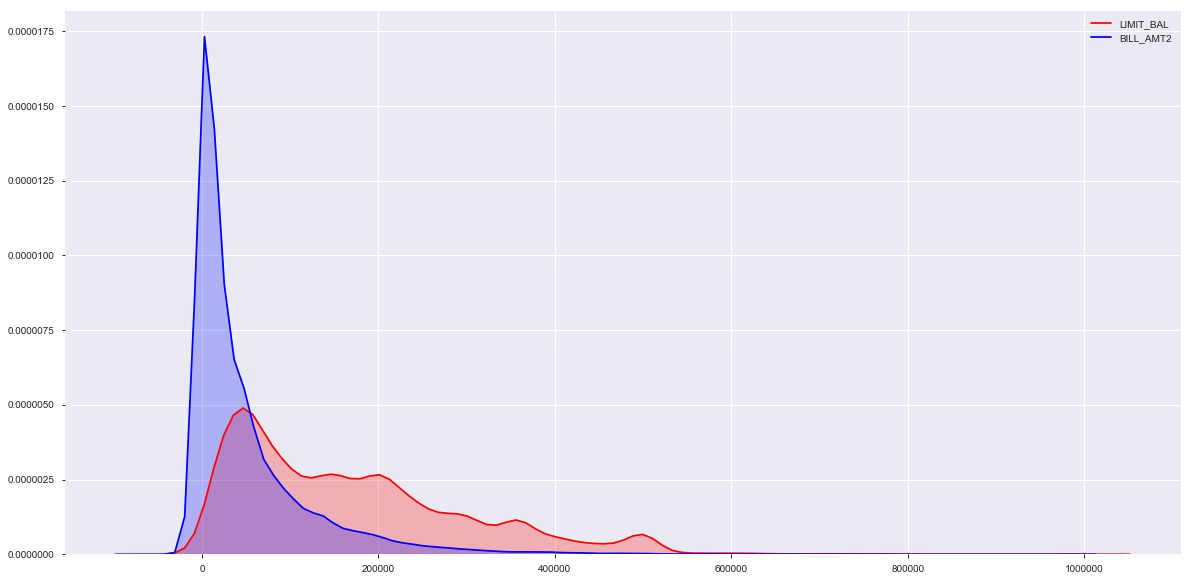

In [85]:
# plot of 2 variables
plt.figure(figsize=(20,10))
p1=sns.kdeplot(df['LIMIT_BAL'], shade=True, color="r")
#plt.yscale('log')
p1=sns.kdeplot(df['BILL_AMT2'], shade=True, color="b")
plt.show()


In [5]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default_0'],
      dtype='object')

In [6]:
df.sample(5)

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
21057      80000    2          3         1   32      2      0      0      0   
2039      200000    2          1         1   38     -2     -2     -2     -2   
525        20000    2          2         2   46      8      7      6      5   
4817      130000    2          2         2   25      1      2      0      0   
5298      360000    1          3         1   42     -1     -1     -1      0   

       PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
21057      2  ...      22919      21890      22003      1700      1400   
2039      -2  ...       2044       1614       2066       690      2753   
525        4  ...      19617      18737      18148         0         0   
4817       0  ...      53590      54606      51033         0      5000   
5298      -1  ...      19433      16708      24047      1815     22674   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default_0  
21057      2400         0      1000      1500          0  
2039       2054      1622      2076       578          0  
525           0         0         0         0          0  
4817       4000      3000      3500     13000          0  
5298         95     16790     24283     17387          0  

[5 rows x 24 columns]

In [ ]:
df.profile_report()

In [ ]:
df.profile_report(style={'full_width':True})

In [ ]:
profile = df.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="output.html")

# baseline + gridsearch + lgbm

In [29]:
y = df['default_0']
x = df.iloc[:, :-1]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

In [39]:
def gridsearch_lgb(X_train, X_test, y_train, y_test):
    estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'auc', 
                        n_estimators = 20, num_leaves = 38)
    param_grid = {
        'n_estimators': [x for x in range(24,40,2)],
        'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2, 0.5]}

    gridsearch = GridSearchCV(estimator, param_grid,verbose=False)
    gridsearch.fit(X_train, y_train,
            eval_set = [(X_test, y_test)],
            eval_metric = ['auc'],
            early_stopping_rounds = 5)
    print()
    print("********************************************")
    print("********************************************")
    print("********************************************")
    print('Best parameters found by grid search are:', gridsearch.best_params_)
    print('best score: {0:.3f}'.format(gridsearch.best_score_))

In [42]:
def train_with_best_params_lgbm(X_train, X_test, y_train, y_test):
    print()
    print()
    print("LGBM: training with best parameters")
    print()
    gbm = lgb.LGBMClassifier(
    learning_rate = gridsearch.best_params_['learning_rate'],
    n_estimators = gridsearch.best_params_['n_estimators'],
    metric= 'auc')

    gbm.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            eval_metric=['auc'],
    early_stopping_rounds=5)

In [41]:
gridsearch_lgb(X_train, X_test, y_train, y_test)
train_with_best_params_lgbm(X_train, X_test, y_train, y_test)

[1]	valid_0's auc: 0.754481
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.761932
[3]	valid_0's auc: 0.764525
[4]	valid_0's auc: 0.767621
[5]	valid_0's auc: 0.769344
[6]	valid_0's auc: 0.770542
[7]	valid_0's auc: 0.772054
[8]	valid_0's auc: 0.771694
[9]	valid_0's auc: 0.772926
[10]	valid_0's auc: 0.773438
[11]	valid_0's auc: 0.773526
[12]	valid_0's auc: 0.774296
[13]	valid_0's auc: 0.77462
[14]	valid_0's auc: 0.774896
[15]	valid_0's auc: 0.774929
[16]	valid_0's auc: 0.775119
[17]	valid_0's auc: 0.775533
[18]	valid_0's auc: 0.775812
[19]	valid_0's auc: 0.775355
[20]	valid_0's auc: 0.77554
[21]	valid_0's auc: 0.775698
[22]	valid_0's auc: 0.776285
[23]	valid_0's auc: 0.777096
[24]	valid_0's auc: 0.777443
Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.777443
[1]	valid_0's auc: 0.760675
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.76468
[3]	valid_0's auc: 0.772466
[4]	valid_0's auc: 0.77049
[5]	vali

[2]	valid_0's auc: 0.761932
[3]	valid_0's auc: 0.764525
[4]	valid_0's auc: 0.767621
[5]	valid_0's auc: 0.769344
[6]	valid_0's auc: 0.770542
[7]	valid_0's auc: 0.772054
[8]	valid_0's auc: 0.771694
[9]	valid_0's auc: 0.772926
[10]	valid_0's auc: 0.773438
[11]	valid_0's auc: 0.773526
[12]	valid_0's auc: 0.774296
[13]	valid_0's auc: 0.77462
[14]	valid_0's auc: 0.774896
[15]	valid_0's auc: 0.774929
[16]	valid_0's auc: 0.775119
[17]	valid_0's auc: 0.775533
[18]	valid_0's auc: 0.775812
[19]	valid_0's auc: 0.775355
[20]	valid_0's auc: 0.77554
[21]	valid_0's auc: 0.775698
[22]	valid_0's auc: 0.776285
[23]	valid_0's auc: 0.777096
[24]	valid_0's auc: 0.777443
[25]	valid_0's auc: 0.777537
[26]	valid_0's auc: 0.777918
[27]	valid_0's auc: 0.777259
[28]	valid_0's auc: 0.777566
[29]	valid_0's auc: 0.777237
[30]	valid_0's auc: 0.777172
[31]	valid_0's auc: 0.776989
Early stopping, best iteration is:
[26]	valid_0's auc: 0.777918
[1]	valid_0's auc: 0.760675
Training until validation scores don't improve f

[2]	valid_0's auc: 0.760369
[3]	valid_0's auc: 0.763237
[4]	valid_0's auc: 0.766238
[5]	valid_0's auc: 0.767689
[6]	valid_0's auc: 0.768711
[7]	valid_0's auc: 0.769202
[8]	valid_0's auc: 0.770601
[9]	valid_0's auc: 0.771051
[10]	valid_0's auc: 0.771451
[11]	valid_0's auc: 0.771363
[12]	valid_0's auc: 0.772287
[13]	valid_0's auc: 0.772403
[14]	valid_0's auc: 0.772945
[15]	valid_0's auc: 0.771954
[16]	valid_0's auc: 0.77155
[17]	valid_0's auc: 0.771474
[18]	valid_0's auc: 0.771444
[19]	valid_0's auc: 0.771246
Early stopping, best iteration is:
[14]	valid_0's auc: 0.772945
[1]	valid_0's auc: 0.754494
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.762324
[3]	valid_0's auc: 0.765429
[4]	valid_0's auc: 0.768687
[5]	valid_0's auc: 0.769577
[6]	valid_0's auc: 0.770615
[7]	valid_0's auc: 0.77219
[8]	valid_0's auc: 0.771822
[9]	valid_0's auc: 0.771203
[10]	valid_0's auc: 0.771929
[11]	valid_0's auc: 0.772445
[12]	valid_0's auc: 0.773571
[13]	valid_0's auc: 0.773

[2]	valid_0's auc: 0.76735
[3]	valid_0's auc: 0.771114
[4]	valid_0's auc: 0.769018
[5]	valid_0's auc: 0.770487
[6]	valid_0's auc: 0.773754
[7]	valid_0's auc: 0.773556
[8]	valid_0's auc: 0.773602
[9]	valid_0's auc: 0.773574
[10]	valid_0's auc: 0.772513
[11]	valid_0's auc: 0.773141
Early stopping, best iteration is:
[6]	valid_0's auc: 0.773754
[1]	valid_0's auc: 0.755736
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.760369
[3]	valid_0's auc: 0.763237
[4]	valid_0's auc: 0.766238
[5]	valid_0's auc: 0.767689
[6]	valid_0's auc: 0.768711
[7]	valid_0's auc: 0.769202
[8]	valid_0's auc: 0.770601
[9]	valid_0's auc: 0.771051
[10]	valid_0's auc: 0.771451
[11]	valid_0's auc: 0.771363
[12]	valid_0's auc: 0.772287
[13]	valid_0's auc: 0.772403
[14]	valid_0's auc: 0.772945
[15]	valid_0's auc: 0.771954
[16]	valid_0's auc: 0.77155
[17]	valid_0's auc: 0.771474
[18]	valid_0's auc: 0.771444
[19]	valid_0's auc: 0.771246
Early stopping, best iteration is:
[14]	valid_0's auc: 

[2]	valid_0's auc: 0.762262
[3]	valid_0's auc: 0.764142
[4]	valid_0's auc: 0.767509
[5]	valid_0's auc: 0.768294
[6]	valid_0's auc: 0.769333
[7]	valid_0's auc: 0.770592
[8]	valid_0's auc: 0.771287
[9]	valid_0's auc: 0.771481
[10]	valid_0's auc: 0.772362
[11]	valid_0's auc: 0.77414
[12]	valid_0's auc: 0.774961
[13]	valid_0's auc: 0.775459
[14]	valid_0's auc: 0.777302
[15]	valid_0's auc: 0.778593
[16]	valid_0's auc: 0.77851
[17]	valid_0's auc: 0.778514
[18]	valid_0's auc: 0.777543
[19]	valid_0's auc: 0.777091
[20]	valid_0's auc: 0.776845
Early stopping, best iteration is:
[15]	valid_0's auc: 0.778593
[1]	valid_0's auc: 0.760675
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.770794
[3]	valid_0's auc: 0.771142
[4]	valid_0's auc: 0.770253
[5]	valid_0's auc: 0.770734
[6]	valid_0's auc: 0.770824
[7]	valid_0's auc: 0.771716
[8]	valid_0's auc: 0.772153
[9]	valid_0's auc: 0.773788
[10]	valid_0's auc: 0.773518
[11]	valid_0's auc: 0.773631
[12]	valid_0's auc: 0.774

[1]	valid_0's auc: 0.754494
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.762262
[3]	valid_0's auc: 0.764142
[4]	valid_0's auc: 0.767509
[5]	valid_0's auc: 0.768294
[6]	valid_0's auc: 0.769333
[7]	valid_0's auc: 0.770592
[8]	valid_0's auc: 0.771287
[9]	valid_0's auc: 0.771481
[10]	valid_0's auc: 0.772362
[11]	valid_0's auc: 0.77414
[12]	valid_0's auc: 0.774961
[13]	valid_0's auc: 0.775459
[14]	valid_0's auc: 0.777302
[15]	valid_0's auc: 0.778593
[16]	valid_0's auc: 0.77851
[17]	valid_0's auc: 0.778514
[18]	valid_0's auc: 0.777543
[19]	valid_0's auc: 0.777091
[20]	valid_0's auc: 0.776845
Early stopping, best iteration is:
[15]	valid_0's auc: 0.778593
[1]	valid_0's auc: 0.760675
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.770794
[3]	valid_0's auc: 0.771142
[4]	valid_0's auc: 0.770253
[5]	valid_0's auc: 0.770734
[6]	valid_0's auc: 0.770824
[7]	valid_0's auc: 0.771716
[8]	valid_0's auc: 0.772153
[9]	valid_0's auc: 0.77

[1]	valid_0's auc: 0.754494
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.763093
[3]	valid_0's auc: 0.765158
[4]	valid_0's auc: 0.767342
[5]	valid_0's auc: 0.768796
[6]	valid_0's auc: 0.77044
[7]	valid_0's auc: 0.771109
[8]	valid_0's auc: 0.770958
[9]	valid_0's auc: 0.772568
[10]	valid_0's auc: 0.772813
[11]	valid_0's auc: 0.773805
[12]	valid_0's auc: 0.774675
[13]	valid_0's auc: 0.774814
[14]	valid_0's auc: 0.776507
[15]	valid_0's auc: 0.776606
[16]	valid_0's auc: 0.776503
[17]	valid_0's auc: 0.776203
[18]	valid_0's auc: 0.775736
[19]	valid_0's auc: 0.775496
[20]	valid_0's auc: 0.775513
Early stopping, best iteration is:
[15]	valid_0's auc: 0.776606
[1]	valid_0's auc: 0.760675
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.770568
[3]	valid_0's auc: 0.772746
[4]	valid_0's auc: 0.770261
[5]	valid_0's auc: 0.770615
[6]	valid_0's auc: 0.770824
[7]	valid_0's auc: 0.773465
[8]	valid_0's auc: 0.772258
[9]	valid_0's auc: 0.7

[2]	valid_0's auc: 0.763005
[3]	valid_0's auc: 0.767846
[4]	valid_0's auc: 0.767899
[5]	valid_0's auc: 0.770375
[6]	valid_0's auc: 0.768606
[7]	valid_0's auc: 0.77054
[8]	valid_0's auc: 0.771031
[9]	valid_0's auc: 0.771103
[10]	valid_0's auc: 0.770759
[11]	valid_0's auc: 0.772559
[12]	valid_0's auc: 0.772344
[13]	valid_0's auc: 0.773963
[14]	valid_0's auc: 0.772893
[15]	valid_0's auc: 0.772143
[16]	valid_0's auc: 0.772067
[17]	valid_0's auc: 0.771923
[18]	valid_0's auc: 0.772088
Early stopping, best iteration is:
[13]	valid_0's auc: 0.773963
[1]	valid_0's auc: 0.760675
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.77001
[3]	valid_0's auc: 0.769702
[4]	valid_0's auc: 0.772174
[5]	valid_0's auc: 0.772352
[6]	valid_0's auc: 0.772148
[7]	valid_0's auc: 0.77298
[8]	valid_0's auc: 0.773718
[9]	valid_0's auc: 0.773404
[10]	valid_0's auc: 0.775112
[11]	valid_0's auc: 0.774045
[12]	valid_0's auc: 0.775526
[13]	valid_0's auc: 0.775419
[14]	valid_0's auc: 0.7765

[18]	valid_0's auc: 0.772088
Early stopping, best iteration is:
[13]	valid_0's auc: 0.773963
[1]	valid_0's auc: 0.760675
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.77001
[3]	valid_0's auc: 0.769702
[4]	valid_0's auc: 0.772174
[5]	valid_0's auc: 0.772352
[6]	valid_0's auc: 0.772148
[7]	valid_0's auc: 0.77298
[8]	valid_0's auc: 0.773718
[9]	valid_0's auc: 0.773404
[10]	valid_0's auc: 0.775112
[11]	valid_0's auc: 0.774045
[12]	valid_0's auc: 0.775526
[13]	valid_0's auc: 0.775419
[14]	valid_0's auc: 0.776521
[15]	valid_0's auc: 0.776682
[16]	valid_0's auc: 0.777652
[17]	valid_0's auc: 0.776632
[18]	valid_0's auc: 0.776659
[19]	valid_0's auc: 0.776247
[20]	valid_0's auc: 0.77552
[21]	valid_0's auc: 0.776567
Early stopping, best iteration is:
[16]	valid_0's auc: 0.777652
[1]	valid_0's auc: 0.755736
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.767284
[3]	valid_0's auc: 0.770341
[4]	valid_0's auc: 0.770263
[5]	valid_0's 

[2]	valid_0's auc: 0.762974
[3]	valid_0's auc: 0.767894
[4]	valid_0's auc: 0.765534
[5]	valid_0's auc: 0.76423
[6]	valid_0's auc: 0.763656
[7]	valid_0's auc: 0.762398
[8]	valid_0's auc: 0.763902
Early stopping, best iteration is:
[3]	valid_0's auc: 0.767894
[1]	valid_0's auc: 0.760667
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.76375
[3]	valid_0's auc: 0.762447
[4]	valid_0's auc: 0.760986
[5]	valid_0's auc: 0.760054
[6]	valid_0's auc: 0.761983
[7]	valid_0's auc: 0.760513
Early stopping, best iteration is:
[2]	valid_0's auc: 0.76375
[1]	valid_0's auc: 0.755736
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.760839
[3]	valid_0's auc: 0.760615
[4]	valid_0's auc: 0.759454
[5]	valid_0's auc: 0.758811
[6]	valid_0's auc: 0.758454
[7]	valid_0's auc: 0.756479
Early stopping, best iteration is:
[2]	valid_0's auc: 0.760839
[1]	valid_0's auc: 0.754494
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc:

# baseline + gridsearch + xgboost

In [10]:
y = df['default_0']
x = df.iloc[:, :-1]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

In [20]:
def gridsearch_xgb(X_train, X_test, y_train, y_test):
    estimator = xgb.XGBClassifier(verbosity=2,
                                  max_depth=4,learning_rate = 0.125,  
                        n_estimators = 20)
    param_grid = {
        'n_estimators': [x for x in range(24,40,2)],
        'max_depth':[2,4,6,8],
        'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2, 0.5]}

    gridsearch_xgb = GridSearchCV(estimator, param_grid,verbose=False)
    gridsearch_xgb.fit(X_train, y_train,
            eval_set = [(X_test, y_test)],
            eval_metric = ['auc'],
            early_stopping_rounds = 5)
    print()
    print("********************************************")
    print("********************************************")
    print("********************************************")
    print('Best parameters found by XGB grid search are:', gridsearch_xgb.best_params_)
    print('best score: {0:.3f}'.format(gridsearch_xgb.best_score_))

In [25]:
def train_with_best_params_xgb(X_train, X_test, y_train, y_test):
    print()
    print()
    print("XGBOOST: training with best parameters")
    print()
    gbm = xgb.XGBClassifier(
    learning_rate = gridsearch_xgb.best_params_['learning_rate'],
    n_estimators = gridsearch_xgb.best_params_['n_estimators'],
        
    base_score= 'auc')

    gbm.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            eval_metric=['auc'],
    early_stopping_rounds=5)

In [26]:
gridsearch_xgb(X_train, X_test, y_train, y_test)

[17:55:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689842
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:55:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.689842
[17:55:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.68982
[17:55:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.706593
[17:55:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_d

[17:55:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.765786
[17:55:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.765849
[17:55:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.765845
[17:55:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.766707
[17:55:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.768481
[17:55:22] INFO: C:\

[11]	validation_0-auc:0.75842
[17:55:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.759382
[17:55:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.76144
[17:55:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.762705
[17:55:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.762371
[17:55:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:

[17:55:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.690111
[17:55:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.701086
[17:55:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.701081
[17:55:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.726873
[17:55:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.74312
[17:55:23] INFO: C:\Jenkin

[17:55:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.764819
[17:55:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.764611
[17:55:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.76573
[17:55:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.768569
[17:55:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.768903
[17:55:23] INFO: C:\J

[3]	validation_0-auc:0.701086
[17:55:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.701081
[17:55:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.726873
[17:55:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.74312
[17:55:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.749415
[17:55:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.749

[17:55:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.764819
[17:55:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.764611
[17:55:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.76573
[17:55:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.768569
[17:55:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.768903
[17:55:25] INFO: C:\J

[17:55:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689365
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:55:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.689484
[17:55:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.690111
[17:55:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.701086
[17:55:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_

[17:55:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.759382
[17:55:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.76144
[17:55:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.762705
[17:55:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.762371
[17:55:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.762664
[17:55:26] INFO: C:\J

[17:55:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.768481
[17:55:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.768499
[17:55:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-auc:0.770063
[17:55:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.770014
[17:55:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.770184
[17:55:26] INFO: C:\

[17:55:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689842
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:55:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.689842
[17:55:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.68982
[17:55:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.706593
[17:55:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_d

[7]	validation_0-auc:0.757359
[17:55:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.758114
[17:55:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.758468
[17:55:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.763058
[17:55:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.763434
[17:55:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0

[17:55:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.763786
[17:55:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.764729
[17:55:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.767042
[17:55:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.76775
[17:55:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.76763
[17:55:28] INFO: C:\Je

[17:55:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-auc:0.770423
[17:55:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.770283
[17:55:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.771271
[17:55:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc:0.771268
[17:55:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[28]	validation_0-auc:0.772426
[17:55:28] INFO: C:\

[17:55:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[30]	validation_0-auc:0.770774
[17:55:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[31]	validation_0-auc:0.77143
[17:55:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[32]	validation_0-auc:0.772295
[17:55:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[33]	validation_0-auc:0.77232
[17:55:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[34]	validation_0-auc:0.773115
[17:55:29] INFO: C:\Je

[17:55:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689842
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:55:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.689842
[17:55:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.68982
[17:55:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.706593
[17:55:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_d

[17:55:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.73033
[17:55:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.746548
[17:55:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.746502
[17:55:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.757359
[17:55:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.758114
[17:55:30] INFO: C:\Jenkin

[17:55:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.749306
[17:55:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.757702
[17:55:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.756934
[17:55:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.756974
[17:55:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.758639
[17:55:31] INFO: C:\Je

[11]	validation_0-auc:0.772573
[17:55:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.77257
[17:55:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.772079
[17:55:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.772231
[17:55:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.772072
[17:55:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_

[11]	validation_0-auc:0.770385
[17:55:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.770302
[17:55:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.769563
[17:55:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.770246
[17:55:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.77113
[17:55:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_

[11]	validation_0-auc:0.776277
[17:55:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.776192
[17:55:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.777016
[17:55:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.777705
[17:55:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.777207
[17:55:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation

[17:55:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.755189
[17:55:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.756839
[17:55:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.756121
[17:55:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.759806
[17:55:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.760837
[17:55:34] INFO: C:\

[17:55:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[26]	validation_0-auc:0.778151
[17:55:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[27]	validation_0-auc:0.778001
Stopping. Best iteration:
[22]	validation_0-auc:0.778364

[17:55:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.74749
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:55:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.750737
[17:55:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74:

[17:55:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.77257
[17:55:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.772079
[17:55:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.772231
[17:55:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.772072
[17:55:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_0-auc:0.772394
Stopping. Best i

[17:55:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.768103
[17:55:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.768531
[17:55:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.769024
[17:55:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.770385
[17:55:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.770302
[17:55:36] INFO: 

[4]	validation_0-auc:0.76814
[17:55:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.77053
[17:55:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.773234
[17:55:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.774125
[17:55:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.774491
[17:55:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0

[17:55:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18]	validation_0-auc:0.773444
[17:55:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation_0-auc:0.773604
[17:55:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[20]	validation_0-auc:0.774105
[17:55:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.774408
[17:55:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.774175
[17:55:37] INFO

[14]	validation_0-auc:0.777705
[17:55:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.777207
[17:55:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_0-auc:0.777797
[17:55:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[17]	validation_0-auc:0.777885
[17:55:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[18]	validation_0-auc:0.777352
[17:55:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation

[0]	validation_0-auc:0.748727
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:55:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.755189
[17:55:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.756839
[17:55:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.756121
[17:55:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.759806
[17:55:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3

[24]	validation_0-auc:0.777571
[17:55:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[25]	validation_0-auc:0.778107
[17:55:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[26]	validation_0-auc:0.778151
[17:55:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[27]	validation_0-auc:0.778001
Stopping. Best iteration:
[22]	validation_0-auc:0.778364

[17:55:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.74749
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:55:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.

[17:55:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.772573
[17:55:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.77257
[17:55:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.772079
[17:55:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.772231
[17:55:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.772072
[17:55:41] INFO:

[6]	validation_0-auc:0.76448
[17:55:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.767711
[17:55:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.768103
[17:55:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.768531
[17:55:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.769024
[17:55:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-au

[20]	validation_0-auc:0.771587
Stopping. Best iteration:
[15]	validation_0-auc:0.772245

[17:55:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.756307
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:55:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.763207
[17:55:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.764895
[17:55:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.765879
[17:55:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90

[17:55:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.757302
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:55:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.763154
[17:55:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.765354
[17:55:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.768023
[17:55:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned node

[1]	validation_0-auc:0.76151
[17:55:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.765206
[17:55:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.765082
[17:55:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.767199
[17:55:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.767505
[17:55:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-au

[20]	validation_0-auc:0.771587
Stopping. Best iteration:
[15]	validation_0-auc:0.772245

[17:55:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.756307
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:55:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.763207
[17:55:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.764895
[17:55:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.765879
[17:55:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90

[17:55:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.757302
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:55:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.763154
[17:55:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.765354
[17:55:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.768023
[17:55:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned node

[1]	validation_0-auc:0.76151
[17:55:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.765206
[17:55:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.765082
[17:55:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.767199
[17:55:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.767505
[17:55:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-au

[20]	validation_0-auc:0.771587
Stopping. Best iteration:
[15]	validation_0-auc:0.772245

[17:55:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.756307
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:55:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.763207
[17:55:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.764895
[17:55:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.765879
[17:55:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90

[17:55:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.757302
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:55:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.763154
[17:55:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.765354
[17:55:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.768023
[17:55:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned node

[1]	validation_0-auc:0.76151
[17:55:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.765206
[17:55:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.765082
[17:55:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.767199
[17:55:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.767505
[17:55:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-au

[20]	validation_0-auc:0.771587
Stopping. Best iteration:
[15]	validation_0-auc:0.772245

[17:55:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.756307
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:55:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.763207
[17:55:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.764895
[17:55:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.765879
[17:55:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90

[17:55:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.757302
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:55:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.763154
[17:55:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.765354
[17:55:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.768023
[17:55:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned node

[1]	validation_0-auc:0.76151
[17:55:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.765206
[17:55:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.765082
[17:55:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.767199
[17:55:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.767505
[17:55:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-au

[17:55:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[21]	validation_0-auc:0.769859
[17:55:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=8
[22]	validation_0-auc:0.769749
[17:55:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=8
[23]	validation_0-auc:0.769346
[17:55:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.754176
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:55:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 prune

[17:55:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.764602
[17:55:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.76481
[17:55:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.76421
[17:55:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.764648
[17:55:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.764763
[17:55:57] I

[17:55:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.763326
[17:55:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.76438
[17:55:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.766975
[17:55:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.768514
[17:55:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.769213
[17:55:58] INFO

[21]	validation_0-auc:0.76542
[17:55:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=8
[22]	validation_0-auc:0.766192
[17:55:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=8
[23]	validation_0-auc:0.766524
[17:56:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[24]	validation_0-auc:0.767117
[17:56:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[25]	validation_0-auc:0.766598
[17:56:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[0]	validat

[11]	validation_0-auc:0.77067
[17:56:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.771565
[17:56:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.772165
[17:56:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.772583
[17:56:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.773255
[17:56:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=8
[16]	valida

[25]	validation_0-auc:0.766598
[17:56:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=8
[26]	validation_0-auc:0.767297
[17:56:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[27]	validation_0-auc:0.767641
[17:56:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.740179
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:56:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.750869
[17:56:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 r

[17:56:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.772583
[17:56:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.773255
[17:56:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.772911
[17:56:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.773292
[17:56:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.77366
[17:56:04] 

[25]	validation_0-auc:0.766598
[17:56:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=8
[26]	validation_0-auc:0.767297
[17:56:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[27]	validation_0-auc:0.767641
[17:56:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[28]	validation_0-auc:0.767413
[17:56:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[29]	validation_0-auc:0.767261
[17:56:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[0]	valida

[11]	validation_0-auc:0.77067
[17:56:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.771565
[17:56:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.772165
[17:56:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.772583
[17:56:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.773255
[17:56:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=8
[16]	valida

[17:56:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=8
[21]	validation_0-auc:0.76542
[17:56:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=8
[22]	validation_0-auc:0.766192
[17:56:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=8
[23]	validation_0-auc:0.766524
[17:56:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[24]	validation_0-auc:0.767117
[17:56:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[25]	validation_0-auc:0.766598
[17:56:08] 

[17:56:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.763411
[17:56:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.763326
[17:56:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.76438
[17:56:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.766975
[17:56:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.768514
[17:56:09] INFO:

[17:56:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.76444
[17:56:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.764602
[17:56:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.76481
[17:56:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.76421
[17:56:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.764648
[17:56:11] IN

[17:56:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[21]	validation_0-auc:0.769859
[17:56:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=8
[22]	validation_0-auc:0.769749
[17:56:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=8
[23]	validation_0-auc:0.769346
[17:56:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=8
[24]	validation_0-auc:0.769436
Stopping. Best iteration:
[19]	validation_0-auc:0.77009

[17:56:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nod

[3]	validation_0-auc:0.756727
[17:56:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.758409
[17:56:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.760012
[17:56:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.759755
[17:56:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.760601
[17:56:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_

[17:56:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.767318
[17:56:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.767262
[17:56:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.769379
[17:56:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.769262
[17:56:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.770085
[17:56:15]

[17:56:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=8
[28]	validation_0-auc:0.775638
[17:56:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[29]	validation_0-auc:0.775154
[17:56:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=8
[30]	validation_0-auc:0.775025
[17:56:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=8
[31]	validation_0-auc:0.774816
[17:56:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=8
[32]	validation_0-auc:0.774809
Stopping. 

[17:56:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.706842
[17:56:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.710989
[17:56:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.75191
[17:56:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.752559
[17:56:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.75688
[17:56:18] INFO: C:\Jenkins

[17:56:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.769457
[17:56:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.769441
[17:56:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.770817
[17:56:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689365
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:56:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, m

[17:56:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.765783
[17:56:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.767168
[17:56:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.770246
[17:56:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.769744
[17:56:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.771337
[17:56:19] INFO: C:\

[17:56:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.746829
[17:56:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.749413
[17:56:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.757959
[17:56:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.757626
[17:56:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.756946
[17:56:19] INFO: C:\Jenki

[17:56:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.772024
[17:56:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.772386
[17:56:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.773852
[17:56:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-auc:0.774508
[17:56:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.775087
[17:56:20] INFO: C:\

[6]	validation_0-auc:0.749413
[17:56:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.757959
[17:56:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.757626
[17:56:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.756946
[17:56:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.757295
[17:56:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.

[20]	validation_0-auc:0.771343
[17:56:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.772024
[17:56:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.772386
[17:56:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.773852
[17:56:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-auc:0.774508
[17:56:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-au

[2]	validation_0-auc:0.701618
[17:56:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.701086
[17:56:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.746253
[17:56:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.746829
[17:56:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.749413
[17:56:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.75

[17:56:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.765783
[17:56:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.767168
[17:56:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.770246
[17:56:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.769744
[17:56:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.771337
[17:56:22] INFO: C:\

[17:56:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.772262
[17:56:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.772338
[17:56:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc:0.772828
[17:56:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[28]	validation_0-auc:0.7733
[17:56:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[29]	validation_0-auc:0.773577
[17:56:22] INFO: C:\Je

[17:56:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.706842
[17:56:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.710989
[17:56:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.75191
[17:56:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.752559
[17:56:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.75688
[17:56:23] INFO: C:\Jenkins

[10]	validation_0-auc:0.763563
[17:56:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.763544
[17:56:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.764041
[17:56:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.765372
[17:56:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.765102
[17:56:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-au

[18]	validation_0-auc:0.768186
[17:56:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.768998
[17:56:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.768691
[17:56:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.770517
[17:56:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.770872
[17:56:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-au

[26]	validation_0-auc:0.775229
[17:56:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc:0.775176
[17:56:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[28]	validation_0-auc:0.775426
[17:56:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[29]	validation_0-auc:0.775578
[17:56:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[30]	validation_0-auc:0.775557
[17:56:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[31]	validation_0-au

[32]	validation_0-auc:0.774311
[17:56:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[33]	validation_0-auc:0.774967
[17:56:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[34]	validation_0-auc:0.77502
[17:56:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[35]	validation_0-auc:0.775184
[17:56:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689365
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:56:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 

[3]	validation_0-auc:0.706842
[17:56:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.710989
[17:56:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.75191
[17:56:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.752559
[17:56:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.75688
[17:56:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.7586

[7]	validation_0-auc:0.758621
[17:56:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.758667
[17:56:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.763126
[17:56:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.763563
[17:56:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.763544
[17:56:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0

[17:56:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.760937
[17:56:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.761151
[17:56:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.763171
[17:56:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.76591
[17:56:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.766245
[17:56:26] INFO: C:\J

[19]	validation_0-auc:0.777018
[17:56:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[20]	validation_0-auc:0.776808
[17:56:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.777035
[17:56:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.77679
[17:56:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23]	validation_0-auc:0.777461
[17:56:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0

[16]	validation_0-auc:0.773542
[17:56:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[17]	validation_0-auc:0.773754
[17:56:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18]	validation_0-auc:0.773136
[17:56:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation_0-auc:0.772935
[17:56:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[20]	validation_0-auc:0.77234
[17:56:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_

[17:56:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.777291
[17:56:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.777979
[17:56:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.777692
[17:56:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.77923
[17:56:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.779267
[17:56:29] INFO: 

[17:56:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.768099
[17:56:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.77051
[17:56:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.770769
[17:56:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.77113
[17:56:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.772171
[17:56:30] INFO: C:\J

[19]	validation_0-auc:0.778751
Stopping. Best iteration:
[14]	validation_0-auc:0.779668

[17:56:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.74749
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:56:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.7507
[17:56:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.751762
[17:56:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.752513
[17:56:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\sr

[17:56:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18]	validation_0-auc:0.776254
[17:56:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation_0-auc:0.777018
[17:56:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[20]	validation_0-auc:0.776808
[17:56:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.777035
[17:56:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.77679
[17:56:31] INFO:

[17:56:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.771039
[17:56:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.77115
[17:56:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.771189
[17:56:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.771735
[17:56:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.772551
[17:56:32] INFO: 

[27]	validation_0-auc:0.777565
[17:56:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[28]	validation_0-auc:0.77767
[17:56:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[29]	validation_0-auc:0.77792
[17:56:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[30]	validation_0-auc:0.777937
Stopping. Best iteration:
[25]	validation_0-auc:0.778037

[17:56:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.746577
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:56:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.9

[17]	validation_0-auc:0.773754
[17:56:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18]	validation_0-auc:0.773136
[17:56:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation_0-auc:0.772935
[17:56:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[20]	validation_0-auc:0.77234
[17:56:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.772133
[17:56:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_

[17:56:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.771253
[17:56:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.774934
[17:56:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.774645
[17:56:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.775626
[17:56:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.777291
[17:56:34] INFO: C:\

[17:56:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.760381
[17:56:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.759528
[17:56:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.766236
[17:56:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.768099
[17:56:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.77051
[17:56:35] INFO: C:\J

[13]	validation_0-auc:0.779267
[17:56:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.779668
[17:56:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.778848
[17:56:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_0-auc:0.778331
[17:56:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[17]	validation_0-auc:0.777697
[17:56:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18]	validation

[11]	validation_0-auc:0.772579
[17:56:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.772928
[17:56:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.772916
[17:56:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.775629
[17:56:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.775196
[17:56:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation

[17:56:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.751762
[17:56:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.752513
[17:56:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.764142
[17:56:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.768049
[17:56:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.768581
[17:56:38] INFO: C:\

[3]	validation_0-auc:0.767662
[17:56:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.767715
[17:56:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.772843
[17:56:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.771993
[17:56:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.77462
[17:56:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-a

[17:56:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.772143
[17:56:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.772849
[17:56:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.773648
[17:56:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.773416
[17:56:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.772866
[17:56:40] I

[14]	validation_0-auc:0.772543
[17:56:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[15]	validation_0-auc:0.772531
[17:56:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[16]	validation_0-auc:0.771928
[17:56:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[17]	validation_0-auc:0.77216
[17:56:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18]	validation_0-auc:0.771954
Stopping. Best iteration:
[13]	validation_0-auc:0.77283

[17:56:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots,

[1]	validation_0-auc:0.763293
[17:56:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.765892
[17:56:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.764832
[17:56:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.766091
[17:56:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.767163
[17:56:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-

[7]	validation_0-auc:0.77462
[17:56:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.775712
[17:56:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.775355
[17:56:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.776869
[17:56:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.777116
[17:56:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[12]	validatio

[11]	validation_0-auc:0.773416
[17:56:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.772866
[17:56:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.772369
[17:56:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[14]	validation_0-auc:0.772324
[17:56:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[15]	validation_0-auc:0.773167
Stopping. Best iteration:
[10]	validation_0-auc:0.773648

[17:56:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 root

[18]	validation_0-auc:0.771954
Stopping. Best iteration:
[13]	validation_0-auc:0.77283

[17:56:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.757302
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:56:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.764642
[17:56:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.765905
[17:56:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.768538
[17:56:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90

[17:56:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.768278
[17:56:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.769555
[17:56:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.769921
[17:56:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.770773
[17:56:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.770703
[17:56:47] INFO:

[11]	validation_0-auc:0.777116
[17:56:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.777664
[17:56:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.777459
[17:56:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[14]	validation_0-auc:0.77755
[17:56:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[15]	validation_0-auc:0.777494
[17:56:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16]	validat

Stopping. Best iteration:
[10]	validation_0-auc:0.773648

[17:56:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.756307
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:56:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.765931
[17:56:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.765987
[17:56:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.767662
[17:56:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: 

[2]	validation_0-auc:0.757863
[17:56:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.760343
[17:56:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.763466
[17:56:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.764079
[17:56:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.765316
[17:56:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_

[20]	validation_0-auc:0.77197
[17:56:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[21]	validation_0-auc:0.772628
[17:56:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=8
[22]	validation_0-auc:0.772798
[17:56:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=8
[23]	validation_0-auc:0.7729
[17:56:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.744826
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:56:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roo

[13]	validation_0-auc:0.768329
[17:56:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.768908
[17:56:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.768632
[17:56:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.769153
[17:56:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.76971
[17:56:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[18]	valida

[17:56:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.761797
[17:56:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.7622
[17:56:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.763238
[17:56:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.765286
[17:56:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.766231
[17:56:54] INFO:

[17:56:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[21]	validation_0-auc:0.768681
[17:56:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=8
[22]	validation_0-auc:0.768761
Stopping. Best iteration:
[17]	validation_0-auc:0.76971

[17:56:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.754176
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:56:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.758839
[17:56:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc

[17:56:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.767474
[17:56:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.767013
[17:56:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.76766
[17:56:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.767026
[17:56:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.766265
[17:56:57] 

[2]	validation_0-auc:0.758705
[17:56:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.76118
[17:56:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.762036
[17:56:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.763363
[17:56:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.766739
[17:56:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0

[14]	validation_0-auc:0.767026
[17:57:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.766265
[17:57:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.767569
[17:57:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.768501
[17:57:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.768424
[17:57:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=8
[19]	valid

[17:57:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.768105
[17:57:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.768146
[17:57:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.768844
[17:57:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.768953
[17:57:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.768425
[17:57:01] IN

[17:57:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.768477
[17:57:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=8
[20]	validation_0-auc:0.768859
[17:57:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[21]	validation_0-auc:0.768587
[17:57:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[22]	validation_0-auc:0.76831
[17:57:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[23]	validation_0-auc:0.768219
[17:57:03] 

[17:57:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.768425
[17:57:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.770052
[17:57:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.770378
[17:57:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.771157
[17:57:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.771399
[17:57:04]

[17:57:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[23]	validation_0-auc:0.768219
[17:57:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=8
[24]	validation_0-auc:0.7672
[17:57:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[25]	validation_0-auc:0.766989
Stopping. Best iteration:
[20]	validation_0-auc:0.768859

[17:57:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.740179
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:57:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc

[17:57:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.771399
[17:57:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.771618
[17:57:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.771492
[17:57:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.771937
[17:57:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.771427
[17:57:07]

Will train until validation_0-auc hasn't improved in 5 rounds.
[17:57:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.751134
[17:57:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.757863
[17:57:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.760343
[17:57:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.763466
[17:57:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned n

[18]	validation_0-auc:0.771937
[17:57:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.771427
[17:57:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=8
[20]	validation_0-auc:0.77197
[17:57:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[21]	validation_0-auc:0.772628
[17:57:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=8
[22]	validation_0-auc:0.772798
[17:57:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=8
[23]	valida

[17:57:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.754672
[17:57:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.757904
[17:57:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.758308
[17:57:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.760744
[17:57:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.762173
[17:57:11] INFO: C:\Jenki

[22]	validation_0-auc:0.773918
[17:57:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.774122
[17:57:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689365
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:57:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.689484
[17:57:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.701618
[17:57:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 e

[16]	validation_0-auc:0.771074
[17:57:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.770706
[17:57:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.771965
[17:57:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.773498
[17:57:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.773864
[17:57:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-au

[17:57:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.758028
[17:57:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.756794
[17:57:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.760003
[17:57:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.761138
[17:57:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.763048
[17:57:13] INFO: C:\Jen

[17:57:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.775597
[17:57:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-auc:0.775945
[17:57:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.775853
[17:57:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.77641
[17:57:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc:0.776369
[17:57:13] INFO: C:\J

[17:57:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.756794
[17:57:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.760003
[17:57:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.761138
[17:57:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.763048
[17:57:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.764795
[17:57:14] INFO: C:\Je

[21]	validation_0-auc:0.774607
[17:57:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.775498
[17:57:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.775597
[17:57:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-auc:0.775945
[17:57:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.775853
[17:57:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-au

[3]	validation_0-auc:0.746785
[17:57:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.747347
[17:57:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.749759
[17:57:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.758352
[17:57:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.758028
[17:57:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.75

[15]	validation_0-auc:0.769145
[17:57:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.771074
[17:57:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.770706
[17:57:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.771965
[17:57:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.773498
[17:57:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-au

[25]	validation_0-auc:0.775523
[17:57:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.775773
[17:57:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc:0.776583
[17:57:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[28]	validation_0-auc:0.776749
[17:57:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[29]	validation_0-auc:0.776865
[17:57:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[30]	validation_0-au

[17:57:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.749776
[17:57:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.754672
[17:57:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.757904
[17:57:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.758308
[17:57:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.760744
[17:57:17] INFO: C:\Jenki

[17:57:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.766661
[17:57:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.766589
[17:57:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.767008
[17:57:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.768205
[17:57:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.768626
[17:57:17] INFO: C:\

[19]	validation_0-auc:0.770887
[17:57:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.770771
[17:57:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.772266
[17:57:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.772094
[17:57:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.772462
[17:57:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-au

[27]	validation_0-auc:0.776369
[17:57:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[28]	validation_0-auc:0.776385
[17:57:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[29]	validation_0-auc:0.776368
[17:57:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[30]	validation_0-auc:0.776809
[17:57:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[31]	validation_0-auc:0.777339
[17:57:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[32]	validation_0-au

[33]	validation_0-auc:0.777362
[17:57:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[34]	validation_0-auc:0.777632
[17:57:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[35]	validation_0-auc:0.777602
[17:57:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689365
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:57:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.689484
[17:57:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 

[17:57:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.749776
[17:57:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.754672
[17:57:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.757904
[17:57:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.758308
[17:57:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.760744
[17:57:20] INFO: C:\Jenki

[7]	validation_0-auc:0.758806
[17:57:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.758748
[17:57:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.76135
[17:57:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.761179
[17:57:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.765422
[17:57:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.

[17:57:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.764795
[17:57:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.765831
[17:57:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.767975
[17:57:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.768361
[17:57:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.769491
[17:57:21] INFO: C:\

[15]	validation_0-auc:0.777724
[17:57:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_0-auc:0.777421
[17:57:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[17]	validation_0-auc:0.778125
[17:57:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18]	validation_0-auc:0.777796
[17:57:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation_0-auc:0.77796
[17:57:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[20]	validation_

[17:57:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.77007
[17:57:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.771867
[17:57:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.773532
[17:57:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.774126
[17:57:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.774006
[17:57:22] INFO: 

[17:57:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.761836
[17:57:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.764323
[17:57:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.768285
[17:57:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.770652
[17:57:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.771258
[17:57:23] INFO: C:\

[16]	validation_0-auc:0.773774
[17:57:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[17]	validation_0-auc:0.774362
[17:57:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18]	validation_0-auc:0.77419
[17:57:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation_0-auc:0.773705
[17:57:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[20]	validation_0-auc:0.774194
[17:57:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_

[6]	validation_0-auc:0.7744
[17:57:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.775566
[17:57:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.777099
[17:57:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.77735
[17:57:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.777495
[17:57:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:

[17:57:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.773817
[17:57:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.774229
Stopping. Best iteration:
[17]	validation_0-auc:0.774362

[17:57:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.748727
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:57:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.755408
[17:57:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74

[17:57:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.77735
[17:57:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.777495
[17:57:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.77857
[17:57:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.77764
[17:57:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.778885
[17:57:26] INFO: C:

[20]	validation_0-auc:0.774194
[17:57:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.773817
[17:57:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.774229
Stopping. Best iteration:
[17]	validation_0-auc:0.774362

[17:57:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.748727
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:57:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.755408
[17:57:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.

[17:57:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.775566
[17:57:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.777099
[17:57:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.77735
[17:57:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.777495
[17:57:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.77857
[17:57:28] INFO: C:\

[17:57:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[17]	validation_0-auc:0.774362
[17:57:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18]	validation_0-auc:0.77419
[17:57:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation_0-auc:0.773705
[17:57:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[20]	validation_0-auc:0.774194
[17:57:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.773817
[17:57:29] INFO:

[17:57:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.761836
[17:57:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.764323
[17:57:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.768285
[17:57:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.770652
[17:57:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.771258
[17:57:30] INFO: C:\

[17:57:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.77007
[17:57:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.771867
[17:57:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.773532
[17:57:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.774126
[17:57:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.774006
[17:57:30] INFO: 

[27]	validation_0-auc:0.779788
[17:57:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[28]	validation_0-auc:0.779812
[17:57:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[29]	validation_0-auc:0.779618
[17:57:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[30]	validation_0-auc:0.77989
[17:57:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[31]	validation_0-auc:0.780436
[17:57:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[32]	validation_

[33]	validation_0-auc:0.782002
[17:57:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[34]	validation_0-auc:0.782258
[17:57:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[35]	validation_0-auc:0.782071
[17:57:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.74749
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:57:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.75066
[17:57:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 

[15]	validation_0-auc:0.777724
[17:57:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_0-auc:0.777421
[17:57:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[17]	validation_0-auc:0.778125
[17:57:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18]	validation_0-auc:0.777796
[17:57:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation_0-auc:0.77796
[17:57:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[20]	validation_

[17:57:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[20]	validation_0-auc:0.780907
[17:57:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.780767
[17:57:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.781118
[17:57:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23]	validation_0-auc:0.780486
[17:57:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[24]	validation_0-auc:0.781173
[17:57:34] INFO

[0]	validation_0-auc:0.757302
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:57:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.764546
[17:57:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.767844
[17:57:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.769208
[17:57:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.76902
[17:57:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots,

[17:57:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.770352
[17:57:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.769526
[17:57:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.770256
[17:57:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.771243
[17:57:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[14]	validation_0-auc:0.770433
[17:57:36]

[14]	validation_0-auc:0.777568
[17:57:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[15]	validation_0-auc:0.777751
[17:57:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[16]	validation_0-auc:0.7774
[17:57:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[17]	validation_0-auc:0.777266
[17:57:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18]	validation_0-auc:0.777187
Stopping. Best iteration:
[13]	validation_0-auc:0.778584

[17:57:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102

[17:57:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.756307
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:57:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.765666
[17:57:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.766942
[17:57:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.767936
[17:57:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes

[21]	validation_0-auc:0.770646
[17:57:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[22]	validation_0-auc:0.769999
[17:57:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[23]	validation_0-auc:0.770258
Stopping. Best iteration:
[18]	validation_0-auc:0.771496

[17:57:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.757302
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:57:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.764546
[17:57:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.

[17:57:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.769191
[17:57:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.770666
[17:57:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.770403
[17:57:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.770352
[17:57:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.769526
[17:57:40] IN

[11]	validation_0-auc:0.77812
[17:57:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.777291
[17:57:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.778584
[17:57:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[14]	validation_0-auc:0.777568
[17:57:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[15]	validation_0-auc:0.777751
[17:57:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[16]	validati

[9]	validation_0-auc:0.770073
[17:57:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.77114
[17:57:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.77165
Stopping. Best iteration:
[6]	validation_0-auc:0.77202

[17:57:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.756307
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:57:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.765666
[17:57:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\

[19]	validation_0-auc:0.770742
[17:57:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[20]	validation_0-auc:0.770899
[17:57:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[21]	validation_0-auc:0.770646
[17:57:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[22]	validation_0-auc:0.769999
[17:57:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[23]	validation_0-auc:0.770258
Stopping. Best iteration:
[18]	validation_0-auc:0.771496

[17:57:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 9

[4]	validation_0-auc:0.767427
[17:57:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.768093
[17:57:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.769157
[17:57:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.769191
[17:57:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.770666
[17:57:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0

[17:57:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.777825
[17:57:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.77812
[17:57:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.777291
[17:57:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.778584
[17:57:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[14]	validation_0-auc:0.777568
[17:57:46] 

[7]	validation_0-auc:0.765398
[17:57:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.766175
[17:57:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.766612
[17:57:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.766677
[17:57:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.767284
[17:57:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[12]	validati

Will train until validation_0-auc hasn't improved in 5 rounds.
[17:57:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.753842
[17:57:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.76049
[17:57:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.76112
[17:57:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.762924
[17:57:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nod

[20]	validation_0-auc:0.770878
[17:57:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[21]	validation_0-auc:0.771505
[17:57:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=8
[22]	validation_0-auc:0.771884
[17:57:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=8
[23]	validation_0-auc:0.771853
[17:57:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=8
[24]	validation_0-auc:0.771952
[17:57:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[25]	valida

[17:57:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.767453
[17:57:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.766677
[17:57:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.765968
[17:57:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.766148
[17:57:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.765832
[17:57:51]

[1]	validation_0-auc:0.757921
[17:57:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.759893
[17:57:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.764235
[17:57:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.763637
[17:57:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.765043
[17:57:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_

[15]	validation_0-auc:0.767774
[17:57:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.767464
[17:57:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.76762
[17:57:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.767562
[17:57:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.766985
[17:57:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[20]	valida

[17:57:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.768106
[17:57:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.768849
[17:57:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.770769
[17:57:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.773197
[17:57:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.771728
[17:57:55] INF

[17]	validation_0-auc:0.76762
[17:57:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.767562
[17:57:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.766985
[17:57:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[20]	validation_0-auc:0.766517
Stopping. Best iteration:
[15]	validation_0-auc:0.767774

[17:57:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.740179
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:57:57] INFO: C:\Jenkins\workspace\xgboost-win64_releas

[17:57:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.770769
[17:57:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.773197
[17:57:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.771728
[17:57:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.77276
[17:57:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.772591
[17:57:58] IN

[17]	validation_0-auc:0.76762
[17:57:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.767562
[17:57:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.766985
[17:58:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[20]	validation_0-auc:0.766517
Stopping. Best iteration:
[15]	validation_0-auc:0.767774

[17:58:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.740179
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:58:00] INFO: C:\Jenkins\workspace\xgboost-win64_releas

[17:58:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.770769
[17:58:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.773197
[17:58:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.771728
[17:58:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.77276
[17:58:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.772591
[17:58:01] IN

[15]	validation_0-auc:0.767774
[17:58:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.767464
[17:58:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.76762
[17:58:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.767562
[17:58:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.766985
[17:58:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[20]	valida

[17:58:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.768106
[17:58:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.768849
[17:58:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.770769
[17:58:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.773197
[17:58:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.771728
[17:58:04] INF

[17:58:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.766677
[17:58:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.765968
[17:58:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.766148
[17:58:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.765832
[17:58:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.767774
[17:58:05]

[0]	validation_0-auc:0.754176
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:58:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.757921
[17:58:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.759893
[17:58:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.764235
[17:58:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.763637
[17:58:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 root

[17:58:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.764188
[17:58:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.763318
[17:58:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.764714
[17:58:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.76534
[17:58:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.767453
[17:58:08] INFO

[17:58:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.725728
[17:58:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.730334
[17:58:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.747459
[17:58:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.757422
[17:58:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.757904
[17:58:09] INFO: C:\Jenki

[17:58:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.773688
[17:58:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.773722
[17:58:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.774016
[17:58:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.773839
[17:58:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689842
Will train until vali

[11]	validation_0-auc:0.765838
[17:58:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.766388
[17:58:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.769743
[17:58:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.771133
[17:58:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.771081
[17:58:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-au

[1]	validation_0-auc:0.689842
[17:58:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.706908
[17:58:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.749842
[17:58:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.754736
[17:58:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.757944
[17:58:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.75

[15]	validation_0-auc:0.771081
[17:58:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.772729
[17:58:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.772622
[17:58:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.773462
[17:58:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.7737
[17:58:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:

[1]	validation_0-auc:0.689842
[17:58:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.706908
[17:58:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.749842
[17:58:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.754736
[17:58:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.757944
[17:58:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.75

[17:58:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.771133
[17:58:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.771081
[17:58:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.772729
[17:58:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.772622
[17:58:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.773462
[17:58:12] INFO: C:\

[25]	validation_0-auc:0.774288
[17:58:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.774451
[17:58:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc:0.774163
[17:58:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[28]	validation_0-auc:0.774123
[17:58:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[29]	validation_0-auc:0.773984
[17:58:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc

[17:58:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.757904
[17:58:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.76363
[17:58:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.763807
[17:58:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.764701
[17:58:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.765134
[17:58:13] INFO: C:\Jenki

[15]	validation_0-auc:0.770653
[17:58:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.771179
[17:58:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.772832
[17:58:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.773066
[17:58:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.773214
[17:58:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-au

[25]	validation_0-auc:0.775327
[17:58:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.775756
[17:58:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc:0.775406
[17:58:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[28]	validation_0-auc:0.776206
[17:58:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[29]	validation_0-auc:0.776831
[17:58:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[30]	validation_0-au

[33]	validation_0-auc:0.777184
[17:58:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689365
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:58:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.69005
[17:58:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.701001
[17:58:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.746169
[17:58:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 ext

[17:58:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.761702
[17:58:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.764208
[17:58:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.76438
[17:58:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.768041
[17:58:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.768687
[17:58:16] INFO: C:\Je

[17:58:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.771081
[17:58:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.772729
[17:58:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.772622
[17:58:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.773462
[17:58:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.7737
[17:58:16] INFO: C:\Je

[20]	validation_0-auc:0.773688
[17:58:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.773722
[17:58:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.774016
[17:58:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.773839
[17:58:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-auc:0.774322
[17:58:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-au

[30]	validation_0-auc:0.776832
[17:58:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[31]	validation_0-auc:0.776932
[17:58:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[32]	validation_0-auc:0.776559
[17:58:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[33]	validation_0-auc:0.777186
[17:58:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[34]	validation_0-auc:0.777037
[17:58:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[35]	validation_0-au

[17:58:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[35]	validation_0-auc:0.777915
[17:58:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[36]	validation_0-auc:0.777839
[17:58:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[37]	validation_0-auc:0.778098
[17:58:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689365
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:58:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, m

[17:58:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.771705
[17:58:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.771962
[17:58:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.771064
[17:58:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.771869
[17:58:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.774316
[17:58:18] INFO: C:

[7]	validation_0-auc:0.768008
[17:58:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.769566
[17:58:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.770123
[17:58:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.77174
[17:58:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.772172
[17:58:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-a

[4]	validation_0-auc:0.773802
[17:58:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.774064
[17:58:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.775921
[17:58:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.776125
[17:58:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.776017
[17:58:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc

[17:58:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.7611
[17:58:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.767646
[17:58:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.770281
[17:58:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.771705
[17:58:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.771962
[17:58:21] INFO: C:\Je

[17:58:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.765722
[17:58:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.767496
[17:58:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.768008
[17:58:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.769566
[17:58:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.770123
[17:58:22] INFO: C:\

[1]	validation_0-auc:0.7618
[17:58:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.764319
[17:58:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.76949
[17:58:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.773802
[17:58:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.774064
[17:58:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.

Stopping. Best iteration:
[18]	validation_0-auc:0.774881

[17:58:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.748727
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:58:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.755426
[17:58:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.757515
[17:58:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.7611
[17:58:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tr

[17:58:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.750633
[17:58:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.751371
[17:58:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.763367
[17:58:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.765567
[17:58:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.765722
[17:58:24] INFO: C:\

[18]	validation_0-auc:0.77729
[17:58:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation_0-auc:0.77724
Stopping. Best iteration:
[14]	validation_0-auc:0.777296

[17:58:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.746577
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:58:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.7618
[17:58:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.764319
[17:58:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\sr

[20]	validation_0-auc:0.774664
[17:58:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.7737
[17:58:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.773436
[17:58:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23]	validation_0-auc:0.774282
Stopping. Best iteration:
[18]	validation_0-auc:0.774881

[17:58:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.748727
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:58:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.9

[17]	validation_0-auc:0.779017
[17:58:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[18]	validation_0-auc:0.778912
Stopping. Best iteration:
[13]	validation_0-auc:0.779369

[17:58:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.74749
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:58:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.750633
[17:58:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.751371
[17:58:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90

[15]	validation_0-auc:0.776324
[17:58:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_0-auc:0.776407
[17:58:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[17]	validation_0-auc:0.776955
[17:58:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18]	validation_0-auc:0.77729
[17:58:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation_0-auc:0.77724
Stopping. Best iteration:
[14]	validation_0-auc:0.777296

[17:58:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 

[17]	validation_0-auc:0.7743
[17:58:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18]	validation_0-auc:0.774881
[17:58:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation_0-auc:0.774622
[17:58:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[20]	validation_0-auc:0.774664
[17:58:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.7737
[17:58:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-a

[23]	validation_0-auc:0.778203
[17:58:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.760164
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:58:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.763785
[17:58:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.765871
[17:58:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.767073
[17:58:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 root

[17:58:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.775915
[17:58:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.776032
[17:58:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.775042
[17:58:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.775801
[17:58:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.775529
[17:58:31] I

[3]	validation_0-auc:0.769575
[17:58:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.771043
[17:58:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.772398
[17:58:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.771131
[17:58:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.772325
[17:58:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0

[5]	validation_0-auc:0.768224
[17:58:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.771474
[17:58:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.771858
[17:58:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.772381
[17:58:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.772498
[17:58:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation

[15]	validation_0-auc:0.776522
[17:58:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[16]	validation_0-auc:0.775967
[17:58:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[17]	validation_0-auc:0.776283
[17:58:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[18]	validation_0-auc:0.777034
[17:58:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[19]	validation_0-auc:0.777351
[17:58:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[20]	validation

[17:58:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.772325
[17:58:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.771569
[17:58:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.771905
[17:58:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.771917
Stopping. Best iteration:
[5]	validation_0-auc:0.772398

[17:58:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, 

[5]	validation_0-auc:0.768224
[17:58:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.771474
[17:58:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.771858
[17:58:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.772381
[17:58:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.772498
[17:58:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation

[17:58:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[16]	validation_0-auc:0.775967
[17:58:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[17]	validation_0-auc:0.776283
[17:58:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[18]	validation_0-auc:0.777034
[17:58:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[19]	validation_0-auc:0.777351
[17:58:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[20]	validation_0-auc:0.778215
[17:58:38] INFO

[5]	validation_0-auc:0.772398
[17:58:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.771131
[17:58:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.772325
[17:58:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.771569
[17:58:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.771905
[17:58:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_

[4]	validation_0-auc:0.768806
[17:58:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.768224
[17:58:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.771474
[17:58:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.771858
[17:58:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.772381
[17:58:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0

[17:58:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[15]	validation_0-auc:0.776522
[17:58:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[16]	validation_0-auc:0.775967
[17:58:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[17]	validation_0-auc:0.776283
[17:58:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[18]	validation_0-auc:0.777034
[17:58:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[19]	validation_0-auc:0.777351
[17:58:41] INFO

[4]	validation_0-auc:0.763995
[17:58:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.763776
[17:58:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.763819
[17:58:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.764796
[17:58:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.76593
[17:58:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0

[9]	validation_0-auc:0.765971
[17:58:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.764245
[17:58:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.765679
[17:58:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.766263
[17:58:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.767198
[17:58:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=8
[14]	valida

[17]	validation_0-auc:0.772437
[17:58:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.772167
[17:58:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.7723
[17:58:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=8
[20]	validation_0-auc:0.772079
[17:58:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[21]	validation_0-auc:0.771652
Stopping. Best iteration:
[16]	validation_0-auc:0.772636

[17:58:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots,

[2]	validation_0-auc:0.76072
[17:58:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.763365
[17:58:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.765915
[17:58:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.768863
[17:58:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.76908
[17:58:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-

[2]	validation_0-auc:0.75872
[17:58:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.763003
[17:58:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.763995
[17:58:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.763776
[17:58:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.763819
[17:58:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0

[7]	validation_0-auc:0.764259
[17:58:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.764588
[17:58:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.765971
[17:58:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.764245
[17:58:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.765679
[17:58:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[12]	validati

[15]	validation_0-auc:0.772234
[17:58:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.772636
[17:58:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.772437
[17:58:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.772167
[17:58:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.7723
[17:58:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=8
[20]	validat

Will train until validation_0-auc hasn't improved in 5 rounds.
[17:58:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.756694
[17:58:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.76072
[17:58:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.763365
[17:58:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.765915
[17:58:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned no

Will train until validation_0-auc hasn't improved in 5 rounds.
[17:58:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.75214
[17:58:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.75872
[17:58:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.763003
[17:58:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.763995
[17:58:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nod

[17:58:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.763599
[17:58:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.764259
[17:58:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.764588
[17:58:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.765971
[17:58:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.764245
[17:58:55] INF

[13]	validation_0-auc:0.771668
[17:58:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.771913
[17:58:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.772234
[17:58:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.772636
[17:58:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.772437
[17:58:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=8
[18]	valid

[17:58:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.772554
[17:58:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.773335
[17:58:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.773129
[17:58:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.774071
[17:58:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.774006
[17:58:57] INFO: C:\

[17:58:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.763895
[17:58:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.763913
[17:58:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.76743
[17:58:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.768178
[17:58:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.769024
[17:58:58] INFO: C:\Jen

[25]	validation_0-auc:0.776877
[17:58:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.68938
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:58:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.689639
[17:58:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.725728
[17:58:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.746907
[17:58:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 ext

[15]	validation_0-auc:0.771003
[17:58:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.770836
[17:58:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.770994
[17:58:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.77188
[17:58:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.771722
[17:58:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc

[3]	validation_0-auc:0.746907
[17:59:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.747459
[17:59:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.75759
[17:59:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.758188
[17:59:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.760692
[17:59:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.765

[17:59:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.77188
[17:59:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.771722
[17:59:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.771727
[17:59:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.772327
[17:59:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.772409
[17:59:00] INFO: C:\J

[1]	validation_0-auc:0.689639
[17:59:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.725728
[17:59:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.746907
[17:59:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.747459
[17:59:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.75759
[17:59:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.758

[17:59:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.770447
[17:59:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.771003
[17:59:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.770836
[17:59:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.770994
[17:59:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.77188
[17:59:01] INFO: C:\J

[25]	validation_0-auc:0.776877
[17:59:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.777308
[17:59:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc:0.776587
[17:59:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[28]	validation_0-auc:0.776268
[17:59:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[29]	validation_0-auc:0.777083
[17:59:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[30]	validation_0-au

[3]	validation_0-auc:0.749192
[17:59:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.750102
[17:59:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.758305
[17:59:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.757968
[17:59:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.760927
[17:59:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.76

[17:59:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.772554
[17:59:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.773335
[17:59:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.773129
[17:59:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.774071
[17:59:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.774006
[17:59:03] INFO: C:\

[23]	validation_0-auc:0.778371
[17:59:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-auc:0.778321
[17:59:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.778717
[17:59:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.778156
[17:59:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc:0.778235
[17:59:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[28]	validation_0-au

[0]	validation_0-auc:0.689842
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:59:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.68982
[17:59:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.706843
[17:59:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.749777
[17:59:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.754572
[17:59:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extr

[17:59:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.766647
[17:59:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.768726
[17:59:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.769304
[17:59:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.771823
[17:59:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.772906
[17:59:05] INFO: C:\

[17:59:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.772327
[17:59:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.772409
[17:59:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.77273
[17:59:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-auc:0.772773
[17:59:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.772963
[17:59:05] INFO: C:\J

[26]	validation_0-auc:0.777308
[17:59:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc:0.776587
[17:59:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[28]	validation_0-auc:0.776268
[17:59:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[29]	validation_0-auc:0.777083
[17:59:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[30]	validation_0-auc:0.777226
[17:59:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[31]	validation_0-au

[4]	validation_0-auc:0.750102
[17:59:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.758305
[17:59:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.757968
[17:59:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.760927
[17:59:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.763895
[17:59:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.76

[17:59:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.774902
[17:59:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.775874
[17:59:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.776724
[17:59:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.776709
[17:59:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.778088
[17:59:07] INFO:

[2]	validation_0-auc:0.763421
[17:59:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.76558
[17:59:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.767577
[17:59:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.769875
[17:59:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.77058
[17:59:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0

[20]	validation_0-auc:0.779123
[17:59:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.779645
[17:59:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.779443
[17:59:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[23]	validation_0-auc:0.779517
[17:59:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[24]	validation_0-auc:0.779289
[17:59:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[25]	validation

[17:59:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.772088
[17:59:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.772238
[17:59:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.772832
[17:59:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.773173
[17:59:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.772406
[17:59:10] INFO

[25]	validation_0-auc:0.779773
[17:59:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[26]	validation_0-auc:0.780586
[17:59:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[27]	validation_0-auc:0.78021
[17:59:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.746577
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:59:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.762349
[17:59:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots,

[17:59:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.772238
[17:59:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.772832
[17:59:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.773173
[17:59:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.772406
[17:59:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.772766
[17:59:11] INFO

[24]	validation_0-auc:0.779289
[17:59:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[25]	validation_0-auc:0.779773
[17:59:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[26]	validation_0-auc:0.780586
[17:59:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[27]	validation_0-auc:0.78021
[17:59:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[28]	validation_0-auc:0.780175
[17:59:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[29]	validation_

[17:59:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.77058
[17:59:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.771496
[17:59:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.772636
[17:59:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.772717
[17:59:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.772088
[17:59:13] INFO: C:\

[17]	validation_0-auc:0.778563
[17:59:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[18]	validation_0-auc:0.779275
[17:59:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation_0-auc:0.779303
[17:59:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[20]	validation_0-auc:0.779123
[17:59:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.779645
[17:59:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation

[17:59:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[27]	validation_0-auc:0.780274
[17:59:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[28]	validation_0-auc:0.780475
[17:59:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[29]	validation_0-auc:0.780308
[17:59:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[30]	validation_0-auc:0.779673
[17:59:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[31]	validation_0-auc:0.779794
[17:59:15] INFO

[4]	validation_0-auc:0.767638
[17:59:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.770377
[17:59:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.773684
[17:59:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.7737
[17:59:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.774145
[17:59:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0

[17:59:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.779068
[17:59:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.778657
[17:59:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_0-auc:0.778856
[17:59:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[17]	validation_0-auc:0.778852
[17:59:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[18]	validation_0-auc:0.779705
[17:59:16] INFO

[21]	validation_0-auc:0.775343
[17:59:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.77468
[17:59:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23]	validation_0-auc:0.775018
[17:59:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[24]	validation_0-auc:0.77518
[17:59:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[25]	validation_0-auc:0.775366
[17:59:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[26]	validation_0

[29]	validation_0-auc:0.780149
[17:59:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[30]	validation_0-auc:0.780088
[17:59:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[31]	validation_0-auc:0.78024
Stopping. Best iteration:
[26]	validation_0-auc:0.780586

[17:59:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.746577
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:59:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.762349
[17:59:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.9

[4]	validation_0-auc:0.767577
[17:59:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.769875
[17:59:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.77058
[17:59:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.771496
[17:59:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.772636
[17:59:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:

[10]	validation_0-auc:0.775874
[17:59:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.776724
[17:59:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.776709
[17:59:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.778088
[17:59:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.778643
[17:59:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation

[17:59:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[20]	validation_0-auc:0.779086
[17:59:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.779318
[17:59:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.779666
[17:59:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23]	validation_0-auc:0.779742
[17:59:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[24]	validation_0-auc:0.779676
[17:59:20] INFO

[27]	validation_0-auc:0.776052
[17:59:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[28]	validation_0-auc:0.776065
[17:59:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[29]	validation_0-auc:0.776195
[17:59:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[30]	validation_0-auc:0.776639
[17:59:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[31]	validation_0-auc:0.777303
[17:59:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[32]	validation

[17:59:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.774091
[17:59:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.774648
[17:59:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.775306
[17:59:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.775509
[17:59:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.775388
[17:59:22] INFO

[9]	validation_0-auc:0.772345
[17:59:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.772227
[17:59:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.772052
[17:59:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.772349
[17:59:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.773096
[17:59:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[14]	validati

[25]	validation_0-auc:0.777039
[17:59:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.760164
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:59:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.763856
[17:59:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.76592
[17:59:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.766605
[17:59:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots

[26]	validation_0-auc:0.776134
[17:59:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[27]	validation_0-auc:0.775849
[17:59:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.756307
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:59:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.766476
[17:59:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.767013
[17:59:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots

[17:59:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.77051
Stopping. Best iteration:
[8]	validation_0-auc:0.772339

[17:59:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.757302
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:59:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.76323
[17:59:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.768121
[17:59:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74:

[9]	validation_0-auc:0.775306
[17:59:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.775509
[17:59:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.775388
[17:59:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.774472
[17:59:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.774626
[17:59:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[14]	validation

[9]	validation_0-auc:0.772345
[17:59:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.772227
[17:59:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.772052
[17:59:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.772349
[17:59:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.773096
[17:59:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[14]	validati

[17:59:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[21]	validation_0-auc:0.777914
[17:59:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[22]	validation_0-auc:0.777604
[17:59:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[23]	validation_0-auc:0.777439
[17:59:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[24]	validation_0-auc:0.777134
[17:59:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[25]	validation_0-auc:0.777039
[17:59:30] INFO

[17:59:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[21]	validation_0-auc:0.776274
[17:59:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[22]	validation_0-auc:0.776126
[17:59:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[23]	validation_0-auc:0.776638
[17:59:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[24]	validation_0-auc:0.776865
[17:59:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[25]	validation_0-auc:0.776828
[17:59:31] INFO

[4]	validation_0-auc:0.76855
[17:59:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.769855
[17:59:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.771742
[17:59:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.771456
[17:59:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.772339
[17:59:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0

[17:59:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.767013
[17:59:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.770432
[17:59:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.773171
[17:59:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.772961
[17:59:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.77351
[17:59:33] INFO: C:

[1]	validation_0-auc:0.76323
[17:59:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.768121
[17:59:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.77028
[17:59:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.770331
[17:59:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.770653
[17:59:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-

[17:59:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.774626
[17:59:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[14]	validation_0-auc:0.775403
[17:59:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[15]	validation_0-auc:0.776044
[17:59:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[16]	validation_0-auc:0.776588
[17:59:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[17]	validation_0-auc:0.777032
[17:59:35] INFO

[17:59:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.769193
[17:59:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.770164
[17:59:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.76988
[17:59:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.771178
[17:59:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.771567
[17:59:37] 

[17:59:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.764894
[17:59:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.764252
[17:59:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.764486
[17:59:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.763467
[17:59:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.764171
[17:59:38] IN

[17:59:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.76995
[17:59:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.769249
[17:59:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.77058
[17:59:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.770378
[17:59:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.769491
[17:59:39] IN

[13]	validation_0-auc:0.769193
[17:59:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.770164
[17:59:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.76988
[17:59:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.771178
[17:59:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.771567
[17:59:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[18]	validat

[17:59:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.760494
[17:59:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.761618
[17:59:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.76366
[17:59:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.764894
[17:59:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.764252
[17:59:42] INFO:

[1]	validation_0-auc:0.757009
[17:59:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.759705
[17:59:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.761047
[17:59:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.765759
[17:59:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.766315
[17:59:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_

[6]	validation_0-auc:0.766806
[17:59:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.768232
[17:59:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.767324
[17:59:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.767946
[17:59:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.767757
[17:59:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=8
[11]	validatio

[17]	validation_0-auc:0.771493
[17:59:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.771176
[17:59:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.770754
[17:59:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[20]	validation_0-auc:0.771127
[17:59:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8
[21]	validation_0-auc:0.770657
[17:59:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=8
[22]	validat

[17:59:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=8
[23]	validation_0-auc:0.772452
[17:59:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[24]	validation_0-auc:0.772842
[17:59:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[25]	validation_0-auc:0.772763
[17:59:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[26]	validation_0-auc:0.772767
[17:59:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[27]	validation_0-auc:0.772461
[17:59:48] INF

[10]	validation_0-auc:0.763467
[17:59:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.764171
[17:59:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.764235
Stopping. Best iteration:
[7]	validation_0-auc:0.764894

[17:59:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.740179
Will train until validation_0-auc hasn't improved in 5 rounds.
[17:59:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.752217
[17:59:49] INFO: C:\Jenkins\workspace\xgboost-win64_release

[17:59:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.76995
[17:59:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.769249
[17:59:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.77058
[17:59:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.770378
[17:59:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.769491
[17:59:51] IN

[13]	validation_0-auc:0.769193
[17:59:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.770164
[17:59:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.76988
[17:59:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.771178
[17:59:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.771567
[17:59:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[18]	validat

[1]	validation_0-auc:0.754342
[17:59:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.758465
[17:59:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.759064
[17:59:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.760494
[17:59:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.761618
[17:59:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_

[5]	validation_0-auc:0.769871
[17:59:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.769872
[17:59:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.771082
[17:59:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.773286
[17:59:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.77224
[17:59:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.77

[4]	validation_0-auc:0.766123
[17:59:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.771874
[17:59:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.772065
[17:59:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.773788
[17:59:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.774347
[17:59:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.77

[20]	validation_0-auc:0.777928
[17:59:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.778147
[17:59:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.777361
[17:59:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.777527
[17:59:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-auc:0.778648
[17:59:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-au

[17:59:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.777619
[17:59:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.777927
[17:59:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.778687
[17:59:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.777238
[17:59:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.776979
[17:59:56] INFO: C:\

[17:59:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.764586
[17:59:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.768265
[17:59:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.767191
[17:59:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.768375
[17:59:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.769564
[17:59:56] INFO: C:\Jenki

[1]	validation_0-auc:0.726366
[17:59:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.745778
[17:59:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.760005
[17:59:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.764884
[17:59:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.769871
[17:59:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.76

[17:59:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.769826
[17:59:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.770329
[17:59:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.770253
[17:59:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.770586
Stopping. Best iteration:
[12]	validation_0-auc:0.770676

[17:59:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_d

[17:59:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.774447
[17:59:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.77435
[17:59:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.77369
[17:59:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.773935
[17:59:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.774304
[17:59:58] INFO: C:\Je

[17:59:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.754332
[17:59:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.762318
[17:59:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.766123
[17:59:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.771874
[17:59:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.772065
[17:59:59] INFO: C:\Jenki

[17]	validation_0-auc:0.77547
[17:59:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.776226
[17:59:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.777663
[17:59:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.777928
[17:59:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.778147
[17:59:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc

[18:00:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.773788
[18:00:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.774347
[18:00:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.773142
[18:00:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.7742
[18:00:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.775763
[18:00:00] INFO: C:\Jenki

[22]	validation_0-auc:0.777361
[18:00:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.777527
[18:00:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-auc:0.778648
[18:00:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.778683
[18:00:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.779481
[18:00:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-au

[18:00:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.775561
[18:00:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.775442
[18:00:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.777182
[18:00:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.777527
[18:00:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.777648
[18:00:01] INFO: C:\

[27]	validation_0-auc:0.779925
[18:00:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[28]	validation_0-auc:0.780031
[18:00:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[29]	validation_0-auc:0.779482
[18:00:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[30]	validation_0-auc:0.779355
[18:00:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[31]	validation_0-auc:0.778962
[18:00:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[32]	validation_0-au

[18:00:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.772166
[18:00:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.770583
[18:00:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.772271
[18:00:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.773164
[18:00:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.774513
[18:00:02] INFO: C:\

[18:00:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.772166
[18:00:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.770583
[18:00:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.772271
[18:00:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.773164
[18:00:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.774513
[18:00:03] INFO: C:\

[18:00:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.772166
[18:00:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.770583
[18:00:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.772271
[18:00:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.773164
[18:00:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.774513
[18:00:04] INFO: C:\

[18:00:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.772166
[18:00:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.770583
[18:00:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.772271
[18:00:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.773164
[18:00:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.774513
[18:00:05] INFO: C:\

[18:00:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.772166
[18:00:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.770583
[18:00:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.772271
[18:00:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.773164
[18:00:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.774513
[18:00:06] INFO: C:\

[18:00:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.772166
[18:00:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.770583
[18:00:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.772271
[18:00:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.773164
[18:00:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.774513
[18:00:06] INFO: C:\

[18:00:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.772166
[18:00:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.770583
[18:00:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.772271
[18:00:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.773164
[18:00:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.774513
[18:00:07] INFO: C:\

[18:00:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.772166
[18:00:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.770583
[18:00:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.772271
[18:00:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.773164
[18:00:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.774513
[18:00:08] INFO: C:\

[18:00:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.769423
[18:00:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.768579
[18:00:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.767152
[18:00:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.767868
[18:00:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.765914
[18:00:09] INFO: C

[2]	validation_0-auc:0.764291
[18:00:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.765399
[18:00:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.762695
[18:00:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.76066
[18:00:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.762028
[18:00:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc

[2]	validation_0-auc:0.764956
[18:00:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.767413
[18:00:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.765077
[18:00:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.766373
[18:00:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.765854
[18:00:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-au

[2]	validation_0-auc:0.765819
[18:00:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.76606
[18:00:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.769259
[18:00:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.767675
[18:00:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.768117
[18:00:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc

[11]	validation_0-auc:0.765914
[18:00:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.765853
Stopping. Best iteration:
[7]	validation_0-auc:0.769423

[18:00:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.760164
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:00:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.763421
[18:00:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.764291
[18:00:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0

[18:00:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.759896
Stopping. Best iteration:
[3]	validation_0-auc:0.765399

[18:00:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.757302
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:00:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.762114
[18:00:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.764956
[18:00:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74:

[7]	validation_0-auc:0.752382
Stopping. Best iteration:
[2]	validation_0-auc:0.755214

[18:00:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.754176
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:00:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.75748
[18:00:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.759127
[18:00:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.760497
[18:00:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.9

[0]	validation_0-auc:0.744826
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:00:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.751141
[18:00:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.7544
[18:00:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.752806
[18:00:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.751972
[18:00:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots,

[4]	validation_0-auc:0.750506
[18:00:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.753226
[18:00:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.753492
[18:00:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.752382
Stopping. Best iteration:
[2]	validation_0-auc:0.755214

[18:00:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.754176
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:00:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.

[9]	validation_0-auc:0.757853
[18:00:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.756355
Stopping. Best iteration:
[5]	validation_0-auc:0.764867

[18:00:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.744826
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:00:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.751141
[18:00:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.7544
[18:00:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.9

[18:00:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.748158
[18:00:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.750506
[18:00:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.753226
[18:00:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.753492
[18:00:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.752382
Stopping. Best 

[7]	validation_0-auc:0.760043
[18:00:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.757534
[18:00:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.757853
[18:00:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.756355
Stopping. Best iteration:
[5]	validation_0-auc:0.764867

[18:00:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.744826
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:00:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.

In [34]:
gridsearch_xgb(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

[18:12:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689842
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:12:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.689842
[18:12:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.68982
[18:12:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.706593
[18:12:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_d

[18:12:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.765786
[18:12:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.765849
[18:12:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.765845
[18:12:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.766707
[18:12:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.768481
[18:12:48] INFO: C:\

[18:12:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.759382
[18:12:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.76144
[18:12:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.762705
[18:12:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.762371
[18:12:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.762664
[18:12:48] INFO: C:\J

[18:12:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.690111
[18:12:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.701086
[18:12:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.701081
[18:12:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.726873
[18:12:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.74312
[18:12:49] INFO: C:\Jenkin

[18:12:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.764819
[18:12:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.764611
[18:12:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.76573
[18:12:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.768569
[18:12:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.768903
[18:12:49] INFO: C:\J

[3]	validation_0-auc:0.701086
[18:12:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.701081
[18:12:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.726873
[18:12:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.74312
[18:12:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.749415
[18:12:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.749

[18:12:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.764819
[18:12:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.764611
[18:12:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.76573
[18:12:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.768569
[18:12:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.768903
[18:12:50] INFO: C:\J

[29]	validation_0-auc:0.770824
[18:12:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689365
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:12:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.689484
[18:12:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.690111
[18:12:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.701086
[18:12:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 ex

[18:12:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.759382
[18:12:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.76144
[18:12:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.762705
[18:12:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.762371
[18:12:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.762664
[18:12:52] INFO: C:\J

[18:12:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.768481
[18:12:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.768499
[18:12:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-auc:0.770063
[18:12:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.770014
[18:12:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.770184
[18:12:52] INFO: C:\

[31]	validation_0-auc:0.771826
[18:12:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689842
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:12:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.689842
[18:12:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.68982
[18:12:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.706593
[18:12:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 ext

[7]	validation_0-auc:0.757359
[18:12:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.758114
[18:12:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.758468
[18:12:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.763058
[18:12:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.763434
[18:12:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0

[15]	validation_0-auc:0.762745
[18:12:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.763786
[18:12:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.764729
[18:12:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.767042
[18:12:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.76775
[18:12:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc

[23]	validation_0-auc:0.768882
[18:12:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-auc:0.770423
[18:12:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.770283
[18:12:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.771271
[18:12:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc:0.771268
[18:12:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[28]	validation_0-au

[18:12:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[30]	validation_0-auc:0.770774
[18:12:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[31]	validation_0-auc:0.77143
[18:12:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[32]	validation_0-auc:0.772295
[18:12:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[33]	validation_0-auc:0.77232
[18:12:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[34]	validation_0-auc:0.773115
[18:12:55] INFO: C:\Je

[35]	validation_0-auc:0.772956
[18:12:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689842
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:12:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.689842
[18:12:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.68982
[18:12:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.706593
[18:12:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 ext

[18:12:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.73033
[18:12:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.746548
[18:12:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.746502
[18:12:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.757359
[18:12:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.758114
[18:12:56] INFO: C:\Jenkin

[18:12:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.749306
[18:12:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.757702
[18:12:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.756934
[18:12:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.756974
[18:12:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.758639
[18:12:57] INFO: C:\Je

[11]	validation_0-auc:0.772573
[18:12:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.77257
[18:12:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.772079
[18:12:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.772231
[18:12:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.772072
[18:12:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_

[18:12:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.770302
[18:12:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.769563
[18:12:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.770246
[18:12:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.77113
[18:12:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_0-auc:0.772206
[18:12:58] INFO:

[11]	validation_0-auc:0.776277
[18:12:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.776192
[18:12:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.777016
[18:12:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.777705
[18:12:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.777207
[18:12:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation

[18:13:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.755189
[18:13:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.756839
[18:13:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.756121
[18:13:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.759806
[18:13:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.760837
[18:13:00] INFO: C:\

[25]	validation_0-auc:0.778107
[18:13:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[26]	validation_0-auc:0.778151
[18:13:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[27]	validation_0-auc:0.778001
Stopping. Best iteration:
[22]	validation_0-auc:0.778364

[18:13:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.74749
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:13:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.750737
[18:13:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.9

[11]	validation_0-auc:0.772573
[18:13:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.77257
[18:13:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.772079
[18:13:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.772231
[18:13:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.772072
[18:13:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_

[7]	validation_0-auc:0.767711
[18:13:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.768103
[18:13:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.768531
[18:13:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.769024
[18:13:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.770385
[18:13:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-

[4]	validation_0-auc:0.76814
[18:13:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.77053
[18:13:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.773234
[18:13:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.774125
[18:13:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.774491
[18:13:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0

[18:13:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18]	validation_0-auc:0.773444
[18:13:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation_0-auc:0.773604
[18:13:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[20]	validation_0-auc:0.774105
[18:13:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.774408
[18:13:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.774175
[18:13:04] INFO

[14]	validation_0-auc:0.777705
[18:13:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.777207
[18:13:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_0-auc:0.777797
[18:13:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[17]	validation_0-auc:0.777885
[18:13:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[18]	validation_0-auc:0.777352
[18:13:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation

[0]	validation_0-auc:0.748727
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:13:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.755189
[18:13:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.756839
[18:13:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.756121
[18:13:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.759806
[18:13:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3

[24]	validation_0-auc:0.777571
[18:13:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[25]	validation_0-auc:0.778107
[18:13:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[26]	validation_0-auc:0.778151
[18:13:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[27]	validation_0-auc:0.778001
Stopping. Best iteration:
[22]	validation_0-auc:0.778364

[18:13:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.74749
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:13:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.

[10]	validation_0-auc:0.771695
[18:13:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.772573
[18:13:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.77257
[18:13:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.772079
[18:13:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.772231
[18:13:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_

[6]	validation_0-auc:0.76448
[18:13:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.767711
[18:13:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.768103
[18:13:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.768531
[18:13:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.769024
[18:13:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-au

Stopping. Best iteration:
[15]	validation_0-auc:0.772245

[18:13:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.756307
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:13:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.763207
[18:13:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.764895
[18:13:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.765879
[18:13:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: 

Will train until validation_0-auc hasn't improved in 5 rounds.
[18:13:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.763154
[18:13:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.765354
[18:13:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.768023
[18:13:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.768218
[18:13:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nod

[2]	validation_0-auc:0.765206
[18:13:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.765082
[18:13:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.767199
[18:13:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.767505
[18:13:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.767176
[18:13:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-a

Will train until validation_0-auc hasn't improved in 5 rounds.
[18:13:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.763207
[18:13:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.764895
[18:13:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.765879
[18:13:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.766327
[18:13:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes,

[1]	validation_0-auc:0.763154
[18:13:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.765354
[18:13:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.768023
[18:13:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.768218
[18:13:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.767509
[18:13:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0

[3]	validation_0-auc:0.765082
[18:13:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.767199
[18:13:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.767505
[18:13:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.767176
[18:13:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.767749
[18:13:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-a

[1]	validation_0-auc:0.763207
[18:13:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.764895
[18:13:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.765879
[18:13:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.766327
[18:13:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.765941
[18:13:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-au

[2]	validation_0-auc:0.765354
[18:13:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.768023
[18:13:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.768218
[18:13:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.767509
[18:13:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.767746
[18:13:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_

[4]	validation_0-auc:0.767199
[18:13:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.767505
[18:13:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.767176
[18:13:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.767749
[18:13:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.768578
[18:13:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-a

[2]	validation_0-auc:0.764895
[18:13:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.765879
[18:13:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.766327
[18:13:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.765941
[18:13:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.771904
[18:13:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-a

[3]	validation_0-auc:0.768023
[18:13:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.768218
[18:13:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.767509
[18:13:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.767746
[18:13:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.768881
[18:13:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_

[5]	validation_0-auc:0.767505
[18:13:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.767176
[18:13:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.767749
[18:13:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.768578
[18:13:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.770054
[18:13:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-

Will train until validation_0-auc hasn't improved in 5 rounds.
[18:13:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.757975
[18:13:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.759403
[18:13:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.761818
[18:13:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.760877
[18:13:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned n

[18:13:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.764763
[18:13:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.765357
[18:13:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[20]	validation_0-auc:0.765436
[18:13:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=8
[21]	validation_0-auc:0.76542
[18:13:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=8
[22]	validation_0-auc:0.766192
[18:13:24] 

[9]	validation_0-auc:0.768514
[18:13:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.769213
[18:13:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.77067
[18:13:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.771565
[18:13:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.772165
[18:13:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[14]	validat

[18:13:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.740179
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:13:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.750869
[18:13:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.758103
[18:13:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.76081
[18:13:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned no

[15]	validation_0-auc:0.773255
[18:13:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.772911
[18:13:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.773292
[18:13:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.77366
[18:13:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.774065
[18:13:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[20]	valida

[18:13:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.750869
[18:13:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.758103
[18:13:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.76081
[18:13:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.762979
[18:13:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.763486
[18:13:29] INFO:

[18:13:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.773292
[18:13:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.77366
[18:13:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.774065
[18:13:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[20]	validation_0-auc:0.773683
[18:13:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[21]	validation_0-auc:0.773644
[18:13:31] 

[28]	validation_0-auc:0.767413
[18:13:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[29]	validation_0-auc:0.767261
[18:13:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.740179
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:13:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.750869
[18:13:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.758103
[18:13:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 ro

[18:13:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.773255
[18:13:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.772911
[18:13:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.773292
[18:13:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.77366
[18:13:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.774065
[18:13:34] 

[24]	validation_0-auc:0.767117
[18:13:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[25]	validation_0-auc:0.766598
[18:13:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=8
[26]	validation_0-auc:0.767297
[18:13:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[27]	validation_0-auc:0.767641
[18:13:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[28]	validation_0-auc:0.767413
[18:13:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[29]	valid

[8]	validation_0-auc:0.766975
[18:13:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.768514
[18:13:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.769213
[18:13:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.77067
[18:13:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.771565
[18:13:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=8
[13]	validati

[16]	validation_0-auc:0.76421
[18:13:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.764648
[18:13:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.764763
[18:13:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.765357
[18:13:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[20]	validation_0-auc:0.765436
[18:13:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=8
[21]	valida

[24]	validation_0-auc:0.769436
Stopping. Best iteration:
[19]	validation_0-auc:0.77009

[18:13:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.754176
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:13:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.757975
[18:13:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.759403
[18:13:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.761818
[18:13:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0

[7]	validation_0-auc:0.760601
[18:13:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.76089
[18:13:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.761709
[18:13:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.762525
[18:13:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.76327
[18:13:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation

[18:13:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.770085
[18:13:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.769761
[18:13:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.7697
[18:13:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.77009
[18:13:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=8
[20]	validation_0-auc:0.769939
[18:13:42] IN

[18:13:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=8
[32]	validation_0-auc:0.774809
Stopping. Best iteration:
[27]	validation_0-auc:0.775755

[18:13:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.744826
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:13:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.749919
[18:13:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.756367
[18:13:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc

[6]	validation_0-auc:0.752559
[18:13:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.75688
[18:13:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.758682
[18:13:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.758933
[18:13:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.760481
[18:13:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.7

[0]	validation_0-auc:0.689365
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:13:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.689484
[18:13:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.701618
[18:13:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.701086
[18:13:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.746253
[18:13:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 ext

[18]	validation_0-auc:0.769744
[18:13:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.771337
[18:13:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.771343
[18:13:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.772024
[18:13:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.772386
[18:13:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-au

[18:13:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.756946
[18:13:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.757295
[18:13:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.761149
[18:13:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.760937
[18:13:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.761151
[18:13:46] INFO: C:\J

[18:13:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.775087
[18:13:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.775229
[18:13:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc:0.775176
[18:13:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.68938
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:13:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, ma

[18:13:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.761149
[18:13:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.760937
[18:13:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.761151
[18:13:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.763171
[18:13:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.76591
[18:13:48] INFO: C:\J

[18:13:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.775087
[18:13:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.775229
[18:13:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc:0.775176
[18:13:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[28]	validation_0-auc:0.775426
[18:13:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[29]	validation_0-auc:0.775578
[18:13:48] INFO: C:\

[18:13:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.757959
[18:13:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.757626
[18:13:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.756946
[18:13:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.757295
[18:13:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.761149
[18:13:49] INFO: C:\Jen

[18:13:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.771337
[18:13:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.771343
[18:13:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.772024
[18:13:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.772386
[18:13:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.773852
[18:13:49] INFO: C:\

[28]	validation_0-auc:0.7733
[18:13:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[29]	validation_0-auc:0.773577
[18:13:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[30]	validation_0-auc:0.773556
[18:13:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[31]	validation_0-auc:0.774451
[18:13:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689365
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:13:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 e

[6]	validation_0-auc:0.752559
[18:13:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.75688
[18:13:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.758682
[18:13:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.758933
[18:13:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.760481
[18:13:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.7

[18:13:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.766342
[18:13:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.766629
[18:13:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.767562
[18:13:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.767661
[18:13:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.769633
[18:13:51] INFO: C:\

[22]	validation_0-auc:0.770872
[18:13:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.771273
[18:13:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-auc:0.771069
[18:13:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.77189
[18:13:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.772825
[18:13:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc

[18:13:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[31]	validation_0-auc:0.775921
[18:13:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[32]	validation_0-auc:0.776514
[18:13:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[33]	validation_0-auc:0.77645
[18:13:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[34]	validation_0-auc:0.776825
[18:13:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[35]	validation_0-auc:0.777152
[18:13:52] INFO: C:\J

[0]	validation_0-auc:0.689365
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:13:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.689484
[18:13:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.701618
[18:13:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.701086
[18:13:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.746253
[18:13:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 ext

[18:13:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.758682
[18:13:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.758933
[18:13:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.760481
[18:13:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.761969
[18:13:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.762732
[18:13:53] INFO: C:\Je

[18:13:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.764041
[18:13:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.765372
[18:13:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.765102
[18:13:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.766342
[18:13:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.766629
[18:13:54] INFO: C:\

[18:13:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.766245
[18:13:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.767385
[18:13:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.768186
[18:13:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.768998
[18:13:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.768691
[18:13:54] INFO: C:\

[23]	validation_0-auc:0.777461
[18:13:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.746577
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:13:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.761847
[18:13:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.764197
[18:13:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.768188
[18:13:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 

[20]	validation_0-auc:0.77234
[18:13:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.772133
[18:13:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.77218
Stopping. Best iteration:
[17]	validation_0-auc:0.773754

[18:13:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.748727
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:13:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.75542
[18:13:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\

[12]	validation_0-auc:0.77923
[18:13:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.779267
[18:13:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.779668
[18:13:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.778848
[18:13:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_0-auc:0.778331
[18:13:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[17]	validation_

[10]	validation_0-auc:0.772171
[18:13:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.772579
[18:13:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.772928
[18:13:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.772916
[18:13:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.775629
[18:13:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation

[3]	validation_0-auc:0.752513
[18:13:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.764142
[18:13:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.768049
[18:13:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.768581
[18:13:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.76953
[18:13:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:

[18:13:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.77679
[18:13:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23]	validation_0-auc:0.777461
[18:13:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[24]	validation_0-auc:0.77784
[18:13:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[25]	validation_0-auc:0.778037
[18:13:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[26]	validation_0-auc:0.777513
[18:13:59] INFO: 

[12]	validation_0-auc:0.771735
[18:14:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.772551
[18:14:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.77338
[18:14:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.773369
[18:14:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_0-auc:0.773542
[18:14:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[17]	validation_

Stopping. Best iteration:
[25]	validation_0-auc:0.778037

[18:14:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.746577
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:14:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.761847
[18:14:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.764197
[18:14:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.768188
[18:14:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: 

[18:14:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.772133
[18:14:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.77218
Stopping. Best iteration:
[17]	validation_0-auc:0.773754

[18:14:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.748727
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:14:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.75542
[18:14:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: 

[7]	validation_0-auc:0.774645
[18:14:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.775626
[18:14:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.777291
[18:14:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.777979
[18:14:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.777692
[18:14:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-

[5]	validation_0-auc:0.766236
[18:14:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.768099
[18:14:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.77051
[18:14:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.770769
[18:14:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.77113
[18:14:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:

[18:14:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_0-auc:0.778331
[18:14:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[17]	validation_0-auc:0.777697
[18:14:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18]	validation_0-auc:0.779301
[18:14:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation_0-auc:0.778751
Stopping. Best iteration:
[14]	validation_0-auc:0.779668

[18:14:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, 

[18:14:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.775629
[18:14:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.775196
[18:14:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_0-auc:0.775279
[18:14:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[17]	validation_0-auc:0.776055
[18:14:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18]	validation_0-auc:0.776254
[18:14:05] INFO

[18:14:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.764142
[18:14:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.768049
[18:14:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.768581
[18:14:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.76953
[18:14:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.770587
[18:14:06] INFO: C:\J

[5]	validation_0-auc:0.772843
[18:14:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.771993
[18:14:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.77462
[18:14:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.775712
[18:14:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.775355
[18:14:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0

[9]	validation_0-auc:0.772849
[18:14:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.773648
[18:14:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.773416
[18:14:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.772866
[18:14:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.772369
[18:14:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[14]	valida

[16]	validation_0-auc:0.771928
[18:14:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[17]	validation_0-auc:0.77216
[18:14:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18]	validation_0-auc:0.771954
Stopping. Best iteration:
[13]	validation_0-auc:0.77283

[18:14:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.757302
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:14:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.764642
[18:14:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.

[3]	validation_0-auc:0.764832
[18:14:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.766091
[18:14:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.767163
[18:14:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.768278
[18:14:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.769555
[18:14:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-

[18:14:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.776869
[18:14:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.777116
[18:14:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.777664
[18:14:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.777459
[18:14:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[14]	validation_0-auc:0.77755
[18:14:11] 

[13]	validation_0-auc:0.772369
[18:14:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[14]	validation_0-auc:0.772324
[18:14:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[15]	validation_0-auc:0.773167
Stopping. Best iteration:
[10]	validation_0-auc:0.773648

[18:14:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.756307
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:14:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.765931
[18:14:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_

Will train until validation_0-auc hasn't improved in 5 rounds.
[18:14:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.764642
[18:14:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.765905
[18:14:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.768538
[18:14:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.768333
[18:14:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned node

[18:14:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.769921
[18:14:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.770773
[18:14:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.770703
[18:14:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.771379
[18:14:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.772501
[18:14:14] INF

[13]	validation_0-auc:0.777459
[18:14:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[14]	validation_0-auc:0.77755
[18:14:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[15]	validation_0-auc:0.777494
[18:14:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16]	validation_0-auc:0.777472
[18:14:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[17]	validation_0-auc:0.776778
Stopping. Best iteration:
[12]	validation_0-auc:0.777664

[18:14:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 

Will train until validation_0-auc hasn't improved in 5 rounds.
[18:14:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.765931
[18:14:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.765987
[18:14:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.767662
[18:14:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.767715
[18:14:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes

[4]	validation_0-auc:0.763466
[18:14:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.764079
[18:14:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.765316
[18:14:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.765315
[18:14:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.765688
[18:14:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_

[22]	validation_0-auc:0.772798
[18:14:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=8
[23]	validation_0-auc:0.7729
[18:14:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.744826
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:14:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.750091
[18:14:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.758804
[18:14:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 root

[18:14:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.769153
[18:14:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.76971
[18:14:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.769523
[18:14:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.768221
[18:14:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=8
[20]	validation_0-auc:0.767971
[18:14:21] 

[7]	validation_0-auc:0.7622
[18:14:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.763238
[18:14:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.765286
[18:14:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.766231
[18:14:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.767474
[18:14:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation

[22]	validation_0-auc:0.768761
Stopping. Best iteration:
[17]	validation_0-auc:0.76971

[18:14:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.754176
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:14:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.758839
[18:14:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.758705
[18:14:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.76118
[18:14:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.

[18:14:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.76766
[18:14:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.767026
[18:14:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.766265
[18:14:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.767569
[18:14:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.768501
[18:14:25] 

[4]	validation_0-auc:0.762036
[18:14:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.763363
[18:14:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.766739
[18:14:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.768105
[18:14:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.768146
[18:14:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_

[16]	validation_0-auc:0.767569
[18:14:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.768501
[18:14:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.768424
[18:14:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.768477
[18:14:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=8
[20]	validation_0-auc:0.768859
[18:14:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[21]	valid

[8]	validation_0-auc:0.768146
[18:14:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.768844
[18:14:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.768953
[18:14:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.768425
[18:14:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.770052
[18:14:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=8
[13]	validat

[18:14:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[21]	validation_0-auc:0.768587
[18:14:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[22]	validation_0-auc:0.76831
[18:14:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[23]	validation_0-auc:0.768219
[18:14:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=8
[24]	validation_0-auc:0.7672
[18:14:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[25]	validation_0-auc:0.766989
Stopping. Bes

[18:14:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.770378
[18:14:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.771157
[18:14:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.771399
[18:14:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.771618
[18:14:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.771492
[18:14:32]

[18:14:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[25]	validation_0-auc:0.766989
Stopping. Best iteration:
[20]	validation_0-auc:0.768859

[18:14:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.740179
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:14:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.751134
[18:14:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.757863
[18:14:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc

[16]	validation_0-auc:0.771618
[18:14:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.771492
[18:14:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.771937
[18:14:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.771427
[18:14:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=8
[20]	validation_0-auc:0.77197
[18:14:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[21]	valida

[2]	validation_0-auc:0.757863
[18:14:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.760343
[18:14:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.763466
[18:14:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.764079
[18:14:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.765316
[18:14:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_

[20]	validation_0-auc:0.77197
[18:14:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[21]	validation_0-auc:0.772628
[18:14:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=8
[22]	validation_0-auc:0.772798
[18:14:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=8
[23]	validation_0-auc:0.7729
[18:14:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=8
[24]	validation_0-auc:0.772238
[18:14:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=8
[25]	validati

[18:14:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.758308
[18:14:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.760744
[18:14:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.762173
[18:14:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.762146
[18:14:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.76363
[18:14:39] INFO: C:\Jenk

[0]	validation_0-auc:0.689365
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:14:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.689484
[18:14:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.701618
[18:14:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.746785
[18:14:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.747347
[18:14:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 ext

[18]	validation_0-auc:0.771965
[18:14:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.773498
[18:14:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.773864
[18:14:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.774607
[18:14:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.775498
[18:14:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-au

[8]	validation_0-auc:0.756794
[18:14:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.760003
[18:14:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.761138
[18:14:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.763048
[18:14:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.764795
[18:14:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:

[24]	validation_0-auc:0.775945
[18:14:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.775853
[18:14:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.77641
[18:14:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc:0.776369
[18:14:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.68938
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:14:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 e

[10]	validation_0-auc:0.761138
[18:14:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.763048
[18:14:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.764795
[18:14:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.765831
[18:14:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.767975
[18:14:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-au

[24]	validation_0-auc:0.775945
[18:14:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.775853
[18:14:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.77641
[18:14:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc:0.776369
[18:14:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[28]	validation_0-auc:0.776385
[18:14:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[29]	validation_0-auc

[18:14:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.758028
[18:14:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.756794
[18:14:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.760003
[18:14:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.761138
[18:14:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.763048
[18:14:43] INFO: C:\Jen

[18:14:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.773498
[18:14:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.773864
[18:14:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.774607
[18:14:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.775498
[18:14:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.775597
[18:14:43] INFO: C:\

[18:14:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[29]	validation_0-auc:0.776865
[18:14:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[30]	validation_0-auc:0.776917
[18:14:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[31]	validation_0-auc:0.777158
[18:14:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689365
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:14:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, m

[6]	validation_0-auc:0.757904
[18:14:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.758308
[18:14:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.760744
[18:14:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.762173
[18:14:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.762146
[18:14:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.

[18:14:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.768205
[18:14:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.768626
[18:14:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.770636
[18:14:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.770753
[18:14:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.772146
[18:14:45] INFO: C:\

[18:14:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.772462
[18:14:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-auc:0.773145
[18:14:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.773227
[18:14:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.773152
[18:14:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc:0.773129
[18:14:46] INFO: C:\

[30]	validation_0-auc:0.776809
[18:14:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[31]	validation_0-auc:0.777339
[18:14:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[32]	validation_0-auc:0.777239
[18:14:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[33]	validation_0-auc:0.777217
[18:14:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[34]	validation_0-auc:0.777615
[18:14:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[35]	validation_0-au

[0]	validation_0-auc:0.689365
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:14:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.689484
[18:14:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.701618
[18:14:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.746785
[18:14:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.747347
[18:14:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 ext

[6]	validation_0-auc:0.757904
[18:14:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.758308
[18:14:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.760744
[18:14:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.762173
[18:14:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.762146
[18:14:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.

[10]	validation_0-auc:0.761179
[18:14:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.765422
[18:14:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.766661
[18:14:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.766589
[18:14:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.767008
[18:14:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-au

[18:14:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.768361
[18:14:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.769491
[18:14:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.769284
[18:14:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.771021
[18:14:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.770887
[18:14:48] INFO: C:\

[18]	validation_0-auc:0.777796
[18:14:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation_0-auc:0.77796
[18:14:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[20]	validation_0-auc:0.778276
[18:14:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.778454
[18:14:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.778327
[18:14:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[23]	validation_

[18:14:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.774126
[18:14:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.774006
[18:14:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.773001
[18:14:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.773333
[18:14:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_0-auc:0.773774
[18:14:50] INFO

[18:14:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.770652
[18:14:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.771258
[18:14:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.7744
[18:14:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.775566
[18:14:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.777099
[18:14:51] INFO: C:\Je

[19]	validation_0-auc:0.773705
[18:14:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[20]	validation_0-auc:0.774194
[18:14:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.773817
[18:14:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.774229
Stopping. Best iteration:
[17]	validation_0-auc:0.774362

[18:14:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.748727
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:14:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0

[18:14:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.777495
[18:14:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.77857
[18:14:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.77764
[18:14:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.778885
[18:14:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.780483
[18:14:52] INFO: 

[0]	validation_0-auc:0.748727
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:14:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.755408
[18:14:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.757524
[18:14:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.760692
[18:14:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.767548
[18:14:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2

[18:14:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.77764
[18:14:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.778885
[18:14:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.780483
[18:14:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.780013
[18:14:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_0-auc:0.779841
[18:14:54] INFO:

Will train until validation_0-auc hasn't improved in 5 rounds.
[18:14:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.755408
[18:14:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.757524
[18:14:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.760692
[18:14:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.767548
[18:14:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes,

[10]	validation_0-auc:0.777495
[18:14:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.77857
[18:14:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.77764
[18:14:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.778885
[18:14:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.780483
[18:14:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0

[20]	validation_0-auc:0.774194
[18:14:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.773817
[18:14:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.774229
Stopping. Best iteration:
[17]	validation_0-auc:0.774362

[18:14:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.748727
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:14:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.755408
[18:14:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.

[4]	validation_0-auc:0.770652
[18:14:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.771258
[18:14:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.7744
[18:14:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.775566
[18:14:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.777099
[18:14:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0

[12]	validation_0-auc:0.774126
[18:14:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.774006
[18:14:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.773001
[18:14:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.773333
[18:14:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_0-auc:0.773774
[18:14:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[17]	validation

[18:14:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[31]	validation_0-auc:0.780436
[18:14:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[32]	validation_0-auc:0.779994
[18:14:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[33]	validation_0-auc:0.780182
[18:14:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[34]	validation_0-auc:0.780181
[18:14:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[35]	validation_0-auc:0.779656
[18:14:59] INFO

[0]	validation_0-auc:0.74749
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:15:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.75066
[18:15:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.751244
[18:15:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.752383
[18:15:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.764317
[18:15:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 

[18]	validation_0-auc:0.777796
[18:15:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation_0-auc:0.77796
[18:15:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[20]	validation_0-auc:0.778276
[18:15:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.778454
[18:15:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.778327
[18:15:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[23]	validation_

[18:15:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23]	validation_0-auc:0.780486
[18:15:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[24]	validation_0-auc:0.781173
[18:15:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[25]	validation_0-auc:0.780966
[18:15:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[26]	validation_0-auc:0.780958
[18:15:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[27]	validation_0-auc:0.781248
[18:15:01] INFO

[2]	validation_0-auc:0.767844
[18:15:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.769208
[18:15:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.76902
[18:15:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.770333
[18:15:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.77202
[18:15:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-

[12]	validation_0-auc:0.770256
[18:15:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.771243
[18:15:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[14]	validation_0-auc:0.770433
[18:15:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[15]	validation_0-auc:0.770986
[18:15:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[16]	validation_0-auc:0.771414
[18:15:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[17]	valida

[17]	validation_0-auc:0.777266
[18:15:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18]	validation_0-auc:0.777187
Stopping. Best iteration:
[13]	validation_0-auc:0.778584

[18:15:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.760164
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:15:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.763688
[18:15:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.766083
[18:15:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0

[2]	validation_0-auc:0.766942
[18:15:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.767936
[18:15:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.772666
[18:15:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.772635
[18:15:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.774981
[18:15:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-

[0]	validation_0-auc:0.757302
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:15:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.764546
[18:15:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.767844
[18:15:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.769208
[18:15:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.76902
[18:15:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots,

[18:15:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.770352
[18:15:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.769526
[18:15:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.770256
[18:15:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.771243
[18:15:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[14]	validation_0-auc:0.770433
[18:15:08]

[14]	validation_0-auc:0.777568
[18:15:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[15]	validation_0-auc:0.777751
[18:15:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[16]	validation_0-auc:0.7774
[18:15:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[17]	validation_0-auc:0.777266
[18:15:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18]	validation_0-auc:0.777187
Stopping. Best iteration:
[13]	validation_0-auc:0.778584

[18:15:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102

[18:15:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.756307
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:15:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.765666
[18:15:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.766942
[18:15:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.767936
[18:15:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes

[18:15:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[22]	validation_0-auc:0.769999
[18:15:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[23]	validation_0-auc:0.770258
Stopping. Best iteration:
[18]	validation_0-auc:0.771496

[18:15:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.757302
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:15:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.764546
[18:15:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74

[18:15:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.769191
[18:15:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.770666
[18:15:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.770403
[18:15:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.770352
[18:15:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.769526
[18:15:12] IN

[18:15:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.777291
[18:15:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.778584
[18:15:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[14]	validation_0-auc:0.777568
[18:15:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[15]	validation_0-auc:0.777751
[18:15:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[16]	validation_0-auc:0.7774
[18:15:13] INF

[9]	validation_0-auc:0.766612
[18:15:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.766677
[18:15:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.767284
[18:15:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.768542
[18:15:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.767672
[18:15:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[14]	valida

[2]	validation_0-auc:0.76049
[18:15:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.76112
[18:15:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.762924
[18:15:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.762555
[18:15:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.764188
[18:15:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-

[22]	validation_0-auc:0.771884
[18:15:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=8
[23]	validation_0-auc:0.771853
[18:15:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=8
[24]	validation_0-auc:0.771952
[18:15:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[25]	validation_0-auc:0.771479
[18:15:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.754176
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:15:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 

[11]	validation_0-auc:0.766677
[18:15:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.765968
[18:15:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.766148
[18:15:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.765832
[18:15:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.767774
[18:15:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=8
[16]	valid

[3]	validation_0-auc:0.764235
[18:15:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.763637
[18:15:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.765043
[18:15:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.768106
[18:15:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.768849
[18:15:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_

[17]	validation_0-auc:0.76762
[18:15:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.767562
[18:15:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.766985
[18:15:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[20]	validation_0-auc:0.766517
Stopping. Best iteration:
[15]	validation_0-auc:0.767774

[18:15:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.740179
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:15:21] INFO: C:\Jenkins\workspace\xgboost-win64_releas

[7]	validation_0-auc:0.768849
[18:15:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.770769
[18:15:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.773197
[18:15:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.771728
[18:15:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.77276
[18:15:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=8
[12]	validatio

[19]	validation_0-auc:0.766985
[18:15:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[20]	validation_0-auc:0.766517
Stopping. Best iteration:
[15]	validation_0-auc:0.767774

[18:15:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.740179
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:15:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.751403
[18:15:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.758373
[18:15:24] INFO: C:\Jenkins\workspace\xgboost-win64_release

[9]	validation_0-auc:0.773197
[18:15:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.771728
[18:15:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.77276
[18:15:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.772591
[18:15:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.772952
[18:15:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=8
[14]	validat

[19]	validation_0-auc:0.766985
[18:15:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[20]	validation_0-auc:0.766517
Stopping. Best iteration:
[15]	validation_0-auc:0.767774

[18:15:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.740179
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:15:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.751403
[18:15:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.758373
[18:15:27] INFO: C:\Jenkins\workspace\xgboost-win64_release

[9]	validation_0-auc:0.773197
[18:15:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.771728
[18:15:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.77276
[18:15:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.772591
[18:15:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.772952
[18:15:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=8
[14]	validat

[17]	validation_0-auc:0.76762
[18:15:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.767562
[18:15:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.766985
[18:15:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[20]	validation_0-auc:0.766517
Stopping. Best iteration:
[15]	validation_0-auc:0.767774

[18:15:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.740179
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:15:30] INFO: C:\Jenkins\workspace\xgboost-win64_releas

[7]	validation_0-auc:0.768849
[18:15:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.770769
[18:15:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.773197
[18:15:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.771728
[18:15:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.77276
[18:15:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=8
[12]	validatio

[12]	validation_0-auc:0.765968
[18:15:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.766148
[18:15:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.765832
[18:15:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.767774
[18:15:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.767464
[18:15:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[17]	valid

[2]	validation_0-auc:0.759893
[18:15:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.764235
[18:15:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.763637
[18:15:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.765043
[18:15:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.768106
[18:15:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_

[7]	validation_0-auc:0.763318
[18:15:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.764714
[18:15:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.76534
[18:15:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.767453
[18:15:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.766677
[18:15:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=8
[12]	validatio

[18:15:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.747459
[18:15:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.757422
[18:15:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.757904
[18:15:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.76363
[18:15:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.763807
[18:15:36] INFO: C:\Jenkin

[18:15:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.774016
[18:15:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.773839
[18:15:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689842
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:15:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.689842
[18:15:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, ma

[18:15:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.771133
[18:15:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.771081
[18:15:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.772729
[18:15:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.772622
[18:15:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.773462
[18:15:37] INFO: C:\

[18:15:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.754736
[18:15:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.757944
[18:15:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.758928
[18:15:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.760988
[18:15:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.762528
[18:15:37] INFO: C:\Jenki

[18:15:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.773462
[18:15:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.7737
[18:15:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.77465
[18:15:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.774037
[18:15:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.774064
[18:15:38] INFO: C:\Jen

[3]	validation_0-auc:0.749842
[18:15:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.754736
[18:15:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.757944
[18:15:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.758928
[18:15:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.760988
[18:15:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.76

[15]	validation_0-auc:0.771081
[18:15:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.772729
[18:15:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.772622
[18:15:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.773462
[18:15:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.7737
[18:15:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:

[18:15:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[28]	validation_0-auc:0.774123
[18:15:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[29]	validation_0-auc:0.773984
[18:15:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689842
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:15:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.689842
[18:15:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, ma

[7]	validation_0-auc:0.76363
[18:15:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.763807
[18:15:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.764701
[18:15:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.765134
[18:15:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.765838
[18:15:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.

[18:15:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.773066
[18:15:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.773214
[18:15:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.773688
[18:15:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.773722
[18:15:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.774016
[18:15:41] INFO: C:\

[27]	validation_0-auc:0.775406
[18:15:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[28]	validation_0-auc:0.776206
[18:15:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[29]	validation_0-auc:0.776831
[18:15:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[30]	validation_0-auc:0.776832
[18:15:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[31]	validation_0-auc:0.776932
[18:15:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[32]	validation_0-au

[18:15:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.701001
[18:15:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.746169
[18:15:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.74673
[18:15:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.749226
[18:15:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.757825
[18:15:42] INFO: C:\Jenkin

[18:15:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.768041
[18:15:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.768687
[18:15:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.770813
[18:15:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.770508
[18:15:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.772069
[18:15:42] INFO: C:\

[17]	validation_0-auc:0.772622
[18:15:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.773462
[18:15:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.7737
[18:15:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.77465
[18:15:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.774037
[18:15:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0

[23]	validation_0-auc:0.773839
[18:15:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-auc:0.774322
[18:15:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.774288
[18:15:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.774451
[18:15:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc:0.774163
[18:15:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[28]	validation_0-au

[33]	validation_0-auc:0.777186
[18:15:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[34]	validation_0-auc:0.777037
[18:15:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[35]	validation_0-auc:0.777129
[18:15:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[36]	validation_0-auc:0.777163
[18:15:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[37]	validation_0-auc:0.777556
[18:15:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc

[37]	validation_0-auc:0.778098
[18:15:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689365
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:15:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.69005
[18:15:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.701001
[18:15:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.746169
[18:15:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 ext

[18:15:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.771869
[18:15:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.774316
[18:15:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.774731
[18:15:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.776031
[18:15:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.775905
[18:15:45] INFO:

[10]	validation_0-auc:0.77174
[18:15:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.772172
[18:15:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.771749
[18:15:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.773186
[18:15:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.773386
[18:15:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_

[18:15:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.776017
[18:15:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.777288
[18:15:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.776516
[18:15:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.777732
[18:15:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.777296
[18:15:47] INFO: 

[5]	validation_0-auc:0.770281
[18:15:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.771705
[18:15:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.771962
[18:15:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.771064
[18:15:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.771869
[18:15:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-au

[7]	validation_0-auc:0.768008
[18:15:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.769566
[18:15:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.770123
[18:15:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.77174
[18:15:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.772172
[18:15:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-a

[4]	validation_0-auc:0.773802
[18:15:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.774064
[18:15:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.775921
[18:15:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.776125
[18:15:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.776017
[18:15:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc

[2]	validation_0-auc:0.757515
[18:15:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.7611
[18:15:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.767646
[18:15:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.770281
[18:15:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.771705
[18:15:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0

[4]	validation_0-auc:0.765567
[18:15:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.765722
[18:15:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.767496
[18:15:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.768008
[18:15:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.769566
[18:15:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc

[1]	validation_0-auc:0.7618
[18:15:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.764319
[18:15:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.76949
[18:15:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.773802
[18:15:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.774064
[18:15:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.

Stopping. Best iteration:
[18]	validation_0-auc:0.774881

[18:15:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.748727
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:15:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.755426
[18:15:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.757515
[18:15:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.7611
[18:15:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tr

[18:15:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.750633
[18:15:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.751371
[18:15:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.763367
[18:15:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.765567
[18:15:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.765722
[18:15:53] INFO: C:\

[18:15:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation_0-auc:0.77724
Stopping. Best iteration:
[14]	validation_0-auc:0.777296

[18:15:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.746577
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:15:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.7618
[18:15:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.764319
[18:15:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tr

[20]	validation_0-auc:0.774664
[18:15:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.7737
[18:15:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.773436
[18:15:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23]	validation_0-auc:0.774282
Stopping. Best iteration:
[18]	validation_0-auc:0.774881

[18:15:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.757302
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:15:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.9

[18:15:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.765871
[18:15:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.767073
[18:15:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.768806
[18:15:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.768224
[18:15:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.771474
[18:15:56] INFO:

[11]	validation_0-auc:0.775042
[18:15:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.775801
[18:15:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.775529
[18:15:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[14]	validation_0-auc:0.77624
[18:15:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[15]	validation_0-auc:0.776522
[18:15:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[16]	validation

[18:15:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.772325
[18:15:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.771569
[18:15:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.771905
[18:15:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.771917
Stopping. Best iteration:
[5]	validation_0-auc:0.772398

[18:15:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, 

[18:15:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.772498
[18:15:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.773043
[18:15:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.77287
[18:15:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.772831
[18:15:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.773026
[18:15:59] IN

[18]	validation_0-auc:0.777034
[18:16:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[19]	validation_0-auc:0.777351
[18:16:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[20]	validation_0-auc:0.778215
[18:16:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[21]	validation_0-auc:0.77813
[18:16:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[22]	validation_0-auc:0.778153
[18:16:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[23]	validation_

[18:16:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.771917
Stopping. Best iteration:
[5]	validation_0-auc:0.772398

[18:16:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.756307
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:16:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.766647
[18:16:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.767127
[18:16:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74:

[8]	validation_0-auc:0.772381
[18:16:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.772498
[18:16:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.773043
[18:16:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.77287
[18:16:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.772831
[18:16:02] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[13]	validatio

[18]	validation_0-auc:0.777034
[18:16:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[19]	validation_0-auc:0.777351
[18:16:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[20]	validation_0-auc:0.778215
[18:16:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[21]	validation_0-auc:0.77813
[18:16:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[22]	validation_0-auc:0.778153
[18:16:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[23]	validation_

[8]	validation_0-auc:0.771569
[18:16:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.771905
[18:16:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.771917
Stopping. Best iteration:
[5]	validation_0-auc:0.772398

[18:16:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.756307
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:16:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.766647
[18:16:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.9

[18:16:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.772381
[18:16:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.772498
[18:16:05] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.773043
[18:16:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.77287
[18:16:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.772831
[18:16:06] INF

[17]	validation_0-auc:0.776283
[18:16:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[18]	validation_0-auc:0.777034
[18:16:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[19]	validation_0-auc:0.777351
[18:16:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[20]	validation_0-auc:0.778215
[18:16:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[21]	validation_0-auc:0.77813
[18:16:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[22]	validation_

[7]	validation_0-auc:0.764796
[18:16:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.76593
[18:16:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.763986
[18:16:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.763182
[18:16:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.76293
[18:16:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation

[18:16:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.767198
[18:16:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.766486
[18:16:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.766632
[18:16:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.766264
[18:16:09] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.766082
[18:16:09]

[20]	validation_0-auc:0.772079
[18:16:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[21]	validation_0-auc:0.771652
Stopping. Best iteration:
[16]	validation_0-auc:0.772636

[18:16:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.744826
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:16:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.753453
[18:16:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.759731
[18:16:11] INFO: C:\Jenkins\workspace\xgboost-win64_release

[18:16:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.76908
[18:16:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.770917
[18:16:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.770603
[18:16:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.771759
[18:16:12] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.771263
[18:16:12] INFO

[18:16:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.763819
[18:16:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.764796
[18:16:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.76593
[18:16:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.763986
[18:16:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.763182
[18:16:14] INFO

[10]	validation_0-auc:0.764245
[18:16:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.765679
[18:16:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.766263
[18:16:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.767198
[18:16:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.766486
[18:16:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=8
[15]	valid

[18]	validation_0-auc:0.772167
[18:16:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.7723
[18:16:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=8
[20]	validation_0-auc:0.772079
[18:16:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[21]	validation_0-auc:0.771652
Stopping. Best iteration:
[16]	validation_0-auc:0.772636

[18:16:16] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.744826
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:16:16] INFO: C:\Jenkins\workspace\xgboost-win64_release

[3]	validation_0-auc:0.763365
[18:16:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.765915
[18:16:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.768863
[18:16:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.76908
[18:16:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.770917
[18:16:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0

[3]	validation_0-auc:0.763003
[18:16:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.763995
[18:16:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.763776
[18:16:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.763819
[18:16:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.764796
[18:16:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_

[8]	validation_0-auc:0.764588
[18:16:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.765971
[18:16:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.764245
[18:16:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.765679
[18:16:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.766263
[18:16:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[13]	validat

[18:16:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.772636
[18:16:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.772437
[18:16:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.772167
[18:16:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.7723
[18:16:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=8
[20]	validation_0-auc:0.772079
[18:16:22] I

[18:16:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.773129
[18:16:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.774071
[18:16:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.774006
[18:16:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.774955
[18:16:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.775367
[18:16:23] INFO: C:\

[9]	validation_0-auc:0.763913
[18:16:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.76743
[18:16:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.768178
[18:16:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.769024
[18:16:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.770881
[18:16:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:

[18:16:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.725728
[18:16:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.746907
[18:16:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.747459
[18:16:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.75759
[18:16:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.758188
[18:16:24] INFO: C:\Jenkin

[18:16:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.77188
[18:16:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.771722
[18:16:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.771727
[18:16:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.772327
[18:16:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.772409
[18:16:25] INFO: C:\J

[18:16:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.758188
[18:16:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.760692
[18:16:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.765326
[18:16:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.766397
[18:16:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.766647
[18:16:25] INFO: C:\Jenk

[18:16:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.771727
[18:16:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.772327
[18:16:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.772409
[18:16:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.77273
[18:16:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-auc:0.772773
[18:16:26] INFO: C:\J

[18:16:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.747459
[18:16:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.75759
[18:16:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.758188
[18:16:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.760692
[18:16:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.765326
[18:16:26] INFO: C:\Jenkin

[18:16:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.770836
[18:16:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.770994
[18:16:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.77188
[18:16:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.771722
[18:16:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.771727
[18:16:27] INFO: C:\J

[18:16:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[28]	validation_0-auc:0.776268
[18:16:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[29]	validation_0-auc:0.777083
[18:16:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[30]	validation_0-auc:0.777226
[18:16:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[31]	validation_0-auc:0.777301
Stopping. Best iteration:
[26]	validation_0-auc:0.777308

[18:16:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_d

[5]	validation_0-auc:0.758305
[18:16:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.757968
[18:16:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.760927
[18:16:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.763895
[18:16:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.763913
[18:16:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.7

[15]	validation_0-auc:0.773335
[18:16:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.773129
[18:16:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.774071
[18:16:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-auc:0.774006
[18:16:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.774955
[18:16:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-au

[25]	validation_0-auc:0.778717
[18:16:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.778156
[18:16:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc:0.778235
[18:16:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[28]	validation_0-auc:0.778414
[18:16:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[29]	validation_0-auc:0.778591
[18:16:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[30]	validation_0-au

[18:16:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.706843
[18:16:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.749777
[18:16:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.754572
[18:16:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.758443
[18:16:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.758092
[18:16:30] INFO: C:\Jenki

[18:16:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.769304
[18:16:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.771823
[18:16:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.772906
[18:16:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.774209
[18:16:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.774344
[18:16:30] INFO: C:\

[18:16:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.77273
[18:16:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-auc:0.772773
[18:16:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.772963
[18:16:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.772899
[18:16:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc:0.773198
[18:16:31] INFO: C:\J

[28]	validation_0-auc:0.776268
[18:16:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[29]	validation_0-auc:0.777083
[18:16:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[30]	validation_0-auc:0.777226
[18:16:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[31]	validation_0-auc:0.777301
Stopping. Best iteration:
[26]	validation_0-auc:0.777308

[18:16:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.68938
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:16:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\s

[18:16:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.760927
[18:16:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.763895
[18:16:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.763913
[18:16:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.76743
[18:16:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.768178
[18:16:32] INFO: C:\Jenk

[18:16:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.776724
[18:16:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.776709
[18:16:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.778088
[18:16:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.778643
[18:16:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.778525
[18:16:32] INFO

[4]	validation_0-auc:0.767577
[18:16:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.769875
[18:16:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.77058
[18:16:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.771496
[18:16:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.772636
[18:16:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:

[22]	validation_0-auc:0.779443
[18:16:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[23]	validation_0-auc:0.779517
[18:16:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[24]	validation_0-auc:0.779289
[18:16:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[25]	validation_0-auc:0.779773
[18:16:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.746577
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:16:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 root

[18:16:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.772832
[18:16:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.773173
[18:16:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.772406
[18:16:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.772766
[18:16:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_0-auc:0.772601
[18:16:35] INFO

[27]	validation_0-auc:0.78021
[18:16:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.746577
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:16:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.762349
[18:16:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.768595
[18:16:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.771203
[18:16:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2

[18:16:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.773173
[18:16:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.772406
[18:16:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.772766
[18:16:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_0-auc:0.772601
[18:16:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[17]	validation_0-auc:0.773913
[18:16:36] INFO

[26]	validation_0-auc:0.780586
[18:16:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[27]	validation_0-auc:0.78021
[18:16:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[28]	validation_0-auc:0.780175
[18:16:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[29]	validation_0-auc:0.780149
[18:16:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.746577
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:16:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots

[18:16:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.772636
[18:16:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.772717
[18:16:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.772088
[18:16:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc:0.772238
[18:16:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12]	validation_0-auc:0.772832
[18:16:38] INFO: 

[19]	validation_0-auc:0.779303
[18:16:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[20]	validation_0-auc:0.779123
[18:16:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-auc:0.779645
[18:16:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.779443
[18:16:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[23]	validation_0-auc:0.779517
[18:16:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[24]	validation

[18:16:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[29]	validation_0-auc:0.780308
[18:16:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[30]	validation_0-auc:0.779673
[18:16:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[31]	validation_0-auc:0.779794
[18:16:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.74749
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:16:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned node

[6]	validation_0-auc:0.773684
[18:16:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.7737
[18:16:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.774145
[18:16:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.774902
[18:16:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.775874
[18:16:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-auc

[18:16:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_0-auc:0.778856
[18:16:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[17]	validation_0-auc:0.778852
[18:16:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[18]	validation_0-auc:0.779705
[18:16:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation_0-auc:0.779374
[18:16:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[20]	validation_0-auc:0.779086
[18:16:41] INFO

[18:16:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[24]	validation_0-auc:0.77518
[18:16:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[25]	validation_0-auc:0.775366
[18:16:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[26]	validation_0-auc:0.775906
[18:16:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[27]	validation_0-auc:0.776052
[18:16:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[28]	validation_0-auc:0.776065
[18:16:42] INFO:

Stopping. Best iteration:
[26]	validation_0-auc:0.780586

[18:16:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.746577
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:16:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.762349
[18:16:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.768595
[18:16:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.771203
[18:16:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: 

[6]	validation_0-auc:0.77058
[18:16:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.771496
[18:16:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.772636
[18:16:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.772717
[18:16:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	validation_0-auc:0.772088
[18:16:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-au

[12]	validation_0-auc:0.776709
[18:16:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-auc:0.778088
[18:16:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-auc:0.778643
[18:16:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-auc:0.778525
[18:16:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[16]	validation_0-auc:0.778436
[18:16:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[17]	validation

[18:16:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[22]	validation_0-auc:0.779666
[18:16:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23]	validation_0-auc:0.779742
[18:16:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[24]	validation_0-auc:0.779676
[18:16:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[25]	validation_0-auc:0.779362
[18:16:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[26]	validation_0-auc:0.779996
[18:16:45] INFO

[29]	validation_0-auc:0.776195
[18:16:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[30]	validation_0-auc:0.776639
[18:16:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[31]	validation_0-auc:0.777303
[18:16:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[32]	validation_0-auc:0.777302
[18:16:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[33]	validation_0-auc:0.777304
[18:16:46] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[34]	validation

[18:16:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.775306
[18:16:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.775509
[18:16:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.775388
[18:16:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.774472
[18:16:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.774626
[18:16:47] INFO

[18:16:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.772349
[18:16:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.773096
[18:16:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[14]	validation_0-auc:0.773348
[18:16:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[15]	validation_0-auc:0.773894
[18:16:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[16]	validation_0-auc:0.774581
[18:16:48] INF

[18:16:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.763856
[18:16:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.76592
[18:16:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.766605
[18:16:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.76855
[18:16:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.769855
[18:16:49] INFO: C

[18:16:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.756307
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:16:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.766476
[18:16:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.767013
[18:16:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.770432
[18:16:50] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes

[13]	validation_0-auc:0.77051
Stopping. Best iteration:
[8]	validation_0-auc:0.772339

[18:16:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.757302
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:16:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.76323
[18:16:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.768121
[18:16:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.77028
[18:16:51] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\

[18:16:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.775388
[18:16:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.774472
[18:16:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.774626
[18:16:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[14]	validation_0-auc:0.775403
[18:16:52] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[15]	validation_0-auc:0.776044
[18:16:52] INFO

[10]	validation_0-auc:0.772227
[18:16:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.772052
[18:16:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.772349
[18:16:53] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[13]	validation_0-auc:0.773096
[18:16:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[14]	validation_0-auc:0.773348
[18:16:54] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[15]	validati

[21]	validation_0-auc:0.777914
[18:16:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[22]	validation_0-auc:0.777604
[18:16:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[23]	validation_0-auc:0.777439
[18:16:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[24]	validation_0-auc:0.777134
[18:16:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[25]	validation_0-auc:0.777039
[18:16:55] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[26]	validation

[21]	validation_0-auc:0.776274
[18:16:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[22]	validation_0-auc:0.776126
[18:16:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[23]	validation_0-auc:0.776638
[18:16:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[24]	validation_0-auc:0.776865
[18:16:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[25]	validation_0-auc:0.776828
[18:16:56] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[26]	validation

[5]	validation_0-auc:0.769855
[18:16:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.771742
[18:16:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.771456
[18:16:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.772339
[18:16:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.77146
[18:16:57] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_

[2]	validation_0-auc:0.767013
[18:16:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.770432
[18:16:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.773171
[18:16:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.772961
[18:16:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.77351
[18:16:58] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-a

[2]	validation_0-auc:0.768121
[18:16:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.77028
[18:16:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.770331
[18:16:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.770653
[18:16:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.770237
[18:16:59] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0

[13]	validation_0-auc:0.774626
[18:17:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[14]	validation_0-auc:0.775403
[18:17:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[15]	validation_0-auc:0.776044
[18:17:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[16]	validation_0-auc:0.776588
[18:17:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[17]	validation_0-auc:0.777032
[18:17:00] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[18]	validation

[13]	validation_0-auc:0.769193
[18:17:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.770164
[18:17:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.76988
[18:17:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.771178
[18:17:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.771567
[18:17:01] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[18]	validat

[7]	validation_0-auc:0.764894
[18:17:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.764252
[18:17:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.764486
[18:17:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.763467
[18:17:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.764171
[18:17:03] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[12]	validati

[18:17:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.769249
[18:17:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.77058
[18:17:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.770378
[18:17:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.769491
[18:17:04] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.770193
[18:17:04] 

[14]	validation_0-auc:0.770164
[18:17:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.76988
[18:17:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.771178
[18:17:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.771567
[18:17:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.771614
[18:17:06] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[19]	validati

[4]	validation_0-auc:0.760494
[18:17:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.761618
[18:17:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.76366
[18:17:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.764894
[18:17:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.764252
[18:17:07] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0

[2]	validation_0-auc:0.759705
[18:17:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.761047
[18:17:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.765759
[18:17:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.766315
[18:17:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.768566
[18:17:08] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_

[7]	validation_0-auc:0.768232
[18:17:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=8
[8]	validation_0-auc:0.767324
[18:17:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=8
[9]	validation_0-auc:0.767946
[18:17:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.767757
[18:17:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.768947
[18:17:10] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=8
[12]	validati

[18:17:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.770754
[18:17:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[20]	validation_0-auc:0.771127
[18:17:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8
[21]	validation_0-auc:0.770657
[18:17:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=8
[22]	validation_0-auc:0.770385
Stopping. Best iteration:
[17]	validation_0-auc:0.771493

[18:17:11] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned node

[23]	validation_0-auc:0.772452
[18:17:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[24]	validation_0-auc:0.772842
[18:17:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[25]	validation_0-auc:0.772763
[18:17:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[26]	validation_0-auc:0.772767
[18:17:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[27]	validation_0-auc:0.772461
[18:17:13] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[28]	validation

[11]	validation_0-auc:0.764171
[18:17:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.764235
Stopping. Best iteration:
[7]	validation_0-auc:0.764894

[18:17:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.740179
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:17:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.752217
[18:17:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.760252
[18:17:14] INFO: C:\Jenkins\workspace\xgboost-win64_release_

[18:17:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.769249
[18:17:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[11]	validation_0-auc:0.77058
[18:17:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=8
[12]	validation_0-auc:0.770378
[18:17:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=8
[13]	validation_0-auc:0.769491
[18:17:15] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=8
[14]	validation_0-auc:0.770193
[18:17:15] 

[18:17:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[15]	validation_0-auc:0.76988
[18:17:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=8
[16]	validation_0-auc:0.771178
[18:17:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=8
[17]	validation_0-auc:0.771567
[18:17:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[18]	validation_0-auc:0.771614
[18:17:17] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[19]	validation_0-auc:0.771832
[18:17:17] IN

[18:17:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.759064
[18:17:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.760494
[18:17:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.761618
[18:17:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.76366
[18:17:18] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.764894
[18:17:18] INFO:

[18:17:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.771082
[18:17:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.773286
[18:17:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.77224
[18:17:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.773065
[18:17:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.774447
[18:17:19] INFO: C:\Jenk

[18:17:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.772065
[18:17:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.773788
[18:17:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.774347
[18:17:19] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.773142
[18:17:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.7742
[18:17:20] INFO: C:\Jenkin

[21]	validation_0-auc:0.778147
[18:17:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.777361
[18:17:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.777527
[18:17:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-auc:0.778648
[18:17:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.778683
[18:17:20] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc

[18]	validation_0-auc:0.777619
[18:17:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.777927
[18:17:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.778687
[18:17:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.777238
[18:17:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.776979
[18:17:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-au

[5]	validation_0-auc:0.764586
[18:17:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.768265
[18:17:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.767191
[18:17:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.768375
[18:17:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.769564
[18:17:21] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.7

[18:17:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.760005
[18:17:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.764884
[18:17:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.769871
[18:17:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.769872
[18:17:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.771082
[18:17:22] INFO: C:\Jenki

[18:17:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.770329
[18:17:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.770253
[18:17:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.770586
Stopping. Best iteration:
[12]	validation_0-auc:0.770676

[18:17:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.689842
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:17:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: t

[11]	validation_0-auc:0.774447
[18:17:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.77435
[18:17:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.77369
[18:17:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.773935
[18:17:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.774304
[18:17:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:

[18:17:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.762318
[18:17:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-auc:0.766123
[18:17:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-auc:0.771874
[18:17:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[6]	validation_0-auc:0.772065
[18:17:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[7]	validation_0-auc:0.773788
[18:17:23] INFO: C:\Jenki

[18:17:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-auc:0.777663
[18:17:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20]	validation_0-auc:0.777928
[18:17:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-auc:0.778147
[18:17:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-auc:0.777361
[18:17:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-auc:0.777527
[18:17:24] INFO: C:\

[7]	validation_0-auc:0.773788
[18:17:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-auc:0.774347
[18:17:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-auc:0.773142
[18:17:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-auc:0.7742
[18:17:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-auc:0.775763
[18:17:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-auc:0.7

[23]	validation_0-auc:0.777527
[18:17:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-auc:0.778648
[18:17:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-auc:0.778683
[18:17:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[26]	validation_0-auc:0.779481
[18:17:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[27]	validation_0-auc:0.779925
[18:17:25] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[28]	validation_0-au

[18:17:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-auc:0.775442
[18:17:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-auc:0.777182
[18:17:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-auc:0.777527
[18:17:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-auc:0.777648
[18:17:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-auc:0.777876
[18:17:26] INFO: C:\

[18:17:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[29]	validation_0-auc:0.779482
[18:17:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[30]	validation_0-auc:0.779355
[18:17:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[31]	validation_0-auc:0.778962
[18:17:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[32]	validation_0-auc:0.778693
[18:17:26] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[33]	validation_0-auc:0.778446
Stopping. Best itera

[4]	validation_0-auc:0.770583
[18:17:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.772271
[18:17:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.773164
[18:17:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.774513
[18:17:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.775862
[18:17:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc

[4]	validation_0-auc:0.770583
[18:17:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.772271
[18:17:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.773164
[18:17:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.774513
[18:17:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.775862
[18:17:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc

[4]	validation_0-auc:0.770583
[18:17:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.772271
[18:17:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.773164
[18:17:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.774513
[18:17:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.775862
[18:17:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc

[4]	validation_0-auc:0.770583
[18:17:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.772271
[18:17:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.773164
[18:17:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.774513
[18:17:29] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.775862
[18:17:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc

[18:17:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.772271
[18:17:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.773164
[18:17:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.774513
[18:17:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.775862
[18:17:30] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.775255
[18:17:30] INFO: C:\

[18:17:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.772271
[18:17:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.773164
[18:17:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.774513
[18:17:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.775862
[18:17:31] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.775255
[18:17:31] INFO: C:\

[18:17:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.772271
[18:17:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.773164
[18:17:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.774513
[18:17:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.775862
[18:17:32] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.775255
[18:17:32] INFO: C:\

[18:17:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation_0-auc:0.772271
[18:17:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[6]	validation_0-auc:0.773164
[18:17:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	validation_0-auc:0.774513
[18:17:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[8]	validation_0-auc:0.775862
[18:17:33] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[9]	validation_0-auc:0.775255
[18:17:33] INFO: C:\

[18:17:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc:0.767152
[18:17:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[10]	validation_0-auc:0.767868
[18:17:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[11]	validation_0-auc:0.765914
[18:17:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[12]	validation_0-auc:0.765853
Stopping. Best iteration:
[7]	validation_0-auc:0.769423

[18:17:34] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, m

[4]	validation_0-auc:0.762695
[18:17:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.76066
[18:17:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.762028
[18:17:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.760003
[18:17:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.759896
Stopping. Best iteration:
[3]	validation_0-auc:0.765399

[18:17:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra

[4]	validation_0-auc:0.765077
[18:17:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.766373
[18:17:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.765854
[18:17:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.765793
[18:17:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.764701
Stopping. Best iteration:
[3]	validation_0-auc:0.767413

[18:17:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extr

[4]	validation_0-auc:0.769259
[18:17:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.767675
[18:17:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[6]	validation_0-auc:0.768117
[18:17:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[7]	validation_0-auc:0.769423
[18:17:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-auc:0.768579
[18:17:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[9]	validation_0-auc

Will train until validation_0-auc hasn't improved in 5 rounds.
[18:17:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.763421
[18:17:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.764291
[18:17:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.765399
[18:17:38] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.762695
[18:17:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nod

Will train until validation_0-auc hasn't improved in 5 rounds.
[18:17:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.762114
[18:17:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.764956
[18:17:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.767413
[18:17:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.765077
[18:17:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nod

[18:17:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.75748
[18:17:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.759127
[18:17:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.760497
[18:17:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.76081
[18:17:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.764867
[18:17:41] INFO: 

[2]	validation_0-auc:0.7544
[18:17:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.752806
[18:17:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.751972
[18:17:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.746873
[18:17:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.746121
[18:17:42] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-

[7]	validation_0-auc:0.752382
Stopping. Best iteration:
[2]	validation_0-auc:0.755214

[18:17:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.754176
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:17:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.75748
[18:17:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.759127
[18:17:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.760497
[18:17:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.9

Will train until validation_0-auc hasn't improved in 5 rounds.
[18:17:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.751141
[18:17:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.7544
[18:17:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.752806
[18:17:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation_0-auc:0.751972
[18:17:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nod

[18:17:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation_0-auc:0.753226
[18:17:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=8
[6]	validation_0-auc:0.753492
[18:17:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[7]	validation_0-auc:0.752382
Stopping. Best iteration:
[2]	validation_0-auc:0.755214

[18:17:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.754176
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:17:47] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:7

[9]	validation_0-auc:0.757853
[18:17:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[10]	validation_0-auc:0.756355
Stopping. Best iteration:
[5]	validation_0-auc:0.764867

[18:17:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.744826
Will train until validation_0-auc hasn't improved in 5 rounds.
[18:17:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.751141
[18:17:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.7544
[18:17:48] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.9

In [27]:
train_with_best_params_xgb(X_train, X_test, y_train, y_test)



XGBOOST: training with best parameters



AttributeError: 'function' object has no attribute 'best_params_'

### this is freezing the computer!

In [11]:
# figure = ff.create_scatterplotmatrix(
#     df[['SEX', 'EDUCATION', 'MARRIAGE',      
#         'AGE','LIMIT_BAL']],
#     diag='histogram',
#     index='EDUCATION')

# figure.show()

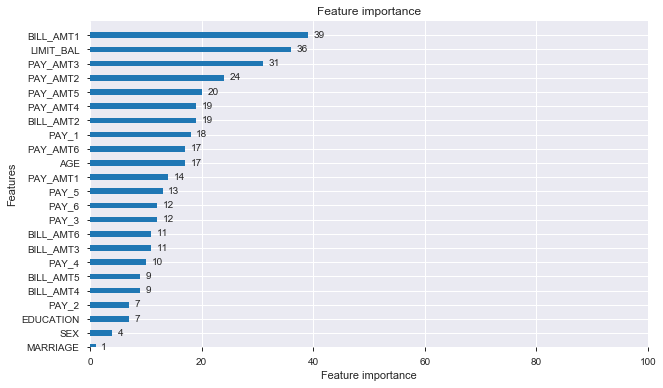

In [13]:
lgb.plot_importance(gbm, height = 0.4, 
                         max_num_features = 25, 
                         xlim = (0,100), ylim = (0,23), 
                         figsize = (10,6))
plt.show()

In [14]:
df.columns.tolist()

['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default_0']

# reduced df after plot imp

In [15]:
reduced_df = df[['LIMIT_BAL','AGE','PAY_1','PAY_3','PAY_5','PAY_6',
 'BILL_AMT1','BILL_AMT2', 'PAY_AMT1','PAY_AMT2',
 'PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','default_0']]

In [17]:
y = reduced_df['default_0']
x = reduced_df.iloc[:, :-1]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.25)

In [21]:
print('Best parameters found by grid search are:', gridsearch.best_params_)
print('best score: {0:.3f}'.format(gridsearch.best_score_))

Best parameters found by grid search are: {'learning_rate': 0.175, 'n_estimators': 24}
best score: 0.821


In [22]:
gbm = lgb.LGBMClassifier(
    learning_rate = gridsearch.best_params_['learning_rate'],
    n_estimators = gridsearch.best_params_['n_estimators'],
    metric= 'auc')

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc'],
early_stopping_rounds=5)

[1]	valid_0's auc: 0.773786
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.778689
[3]	valid_0's auc: 0.780724
[4]	valid_0's auc: 0.783188
[5]	valid_0's auc: 0.785089
[6]	valid_0's auc: 0.785343
[7]	valid_0's auc: 0.784654
[8]	valid_0's auc: 0.786566
[9]	valid_0's auc: 0.786252
[10]	valid_0's auc: 0.786086
[11]	valid_0's auc: 0.786552
[12]	valid_0's auc: 0.785904
[13]	valid_0's auc: 0.787115
[14]	valid_0's auc: 0.787864
[15]	valid_0's auc: 0.78777
[16]	valid_0's auc: 0.787422
[17]	valid_0's auc: 0.787594
[18]	valid_0's auc: 0.787085
[19]	valid_0's auc: 0.787345
Early stopping, best iteration is:
[14]	valid_0's auc: 0.787864


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.175, max_depth=-1,
               metric='auc', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=24, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

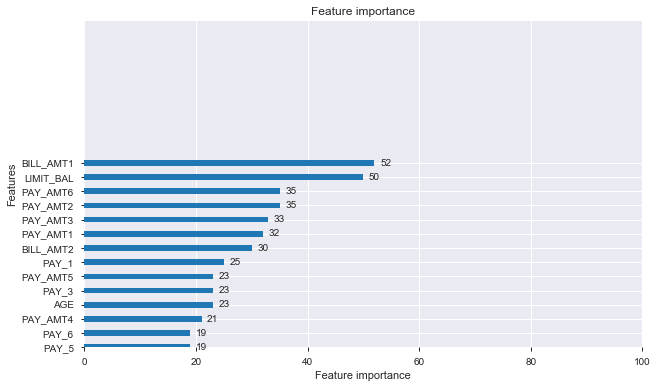

In [23]:
lgb.plot_importance(gbm, height = 0.4, 
                         max_num_features = 25, 
                         xlim = (0,100), ylim = (0,23), 
                         figsize = (10,6))
plt.show()

In [88]:
df.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1      90000    2          2         2   34      0      0      0      0   
2      50000    2          2         1   37      0      0      0      0   
3      50000    1          2         1   57     -1      0     -1      0   
4      50000    1          1         2   37      0      0      0      0   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     -2  ...          0          0          0         0       689         0   
1      0  ...      14331      14948      15549      1518      1500      1000   
2      0  ...      28314      28959      29547      2000      2019      1200   
3      0  ...      20940      19146      19131      2000     36681     10000   
4      0  ...      19394      19619      20024      2500      1815       657   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default_0  
0         0         0         0          1  
1      1000      1000      5000          0  
2      1100      1069      1000          0  
3      9000       689       679          0  
4      1000      1000       800          0  

[5 rows x 24 columns]

In [99]:
from pandas.plotting import scatter_matrix

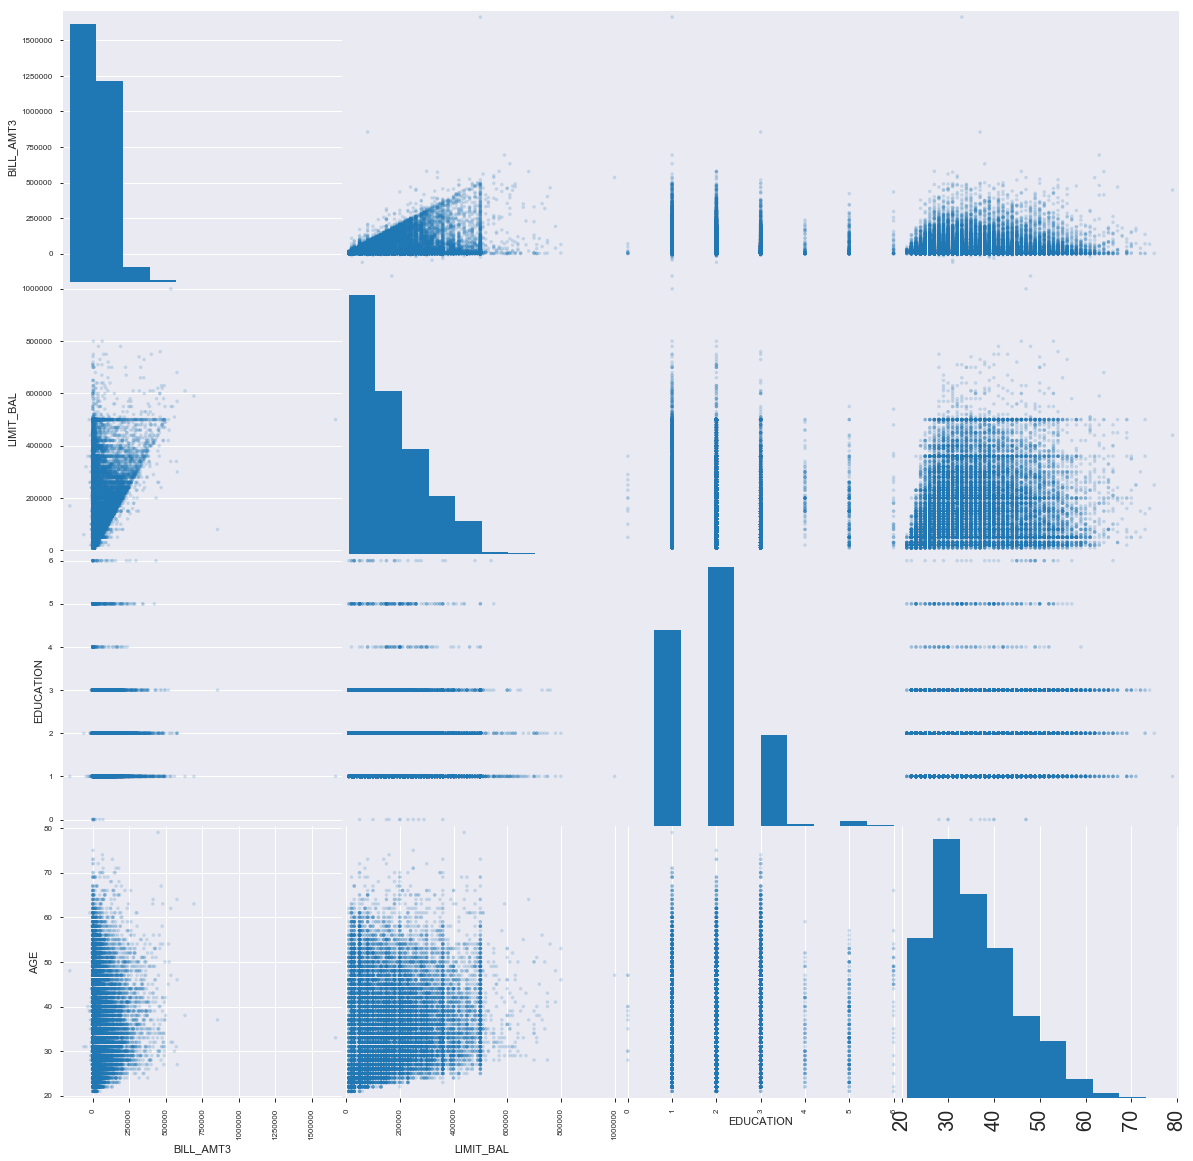

In [111]:
#plt.figure(figsize=(20,20))
scatter_matrix(df[['BILL_AMT3', 'LIMIT_BAL', 'EDUCATION', 'AGE']], alpha=0.2,figsize=(20,20))
plt.xticks(size=20)
#plt.xlabel(size=20,s=)
plt.show()

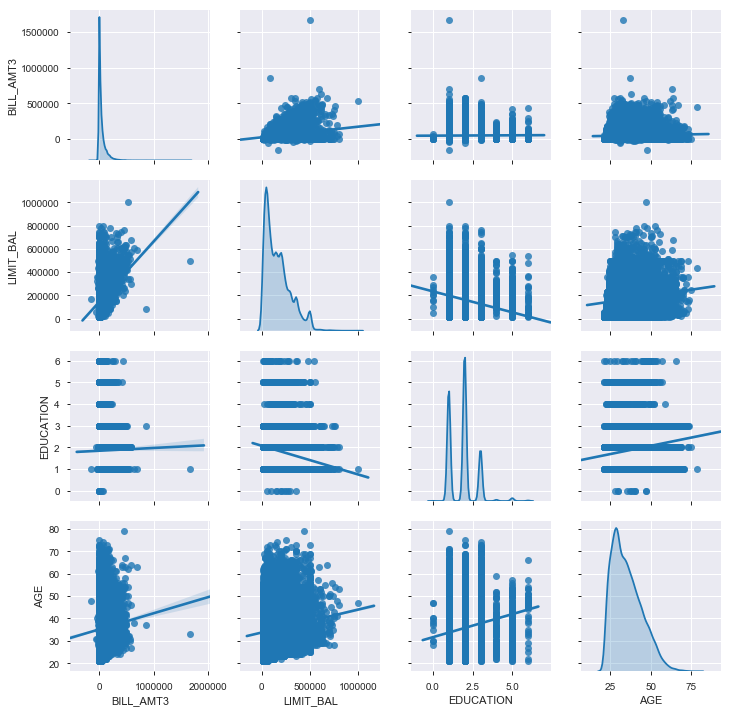

In [96]:
sns.pairplot(data = df[['BILL_AMT3', 'LIMIT_BAL', 'EDUCATION', 'AGE']],kind='reg', diag_kind='kde')
plt.show()

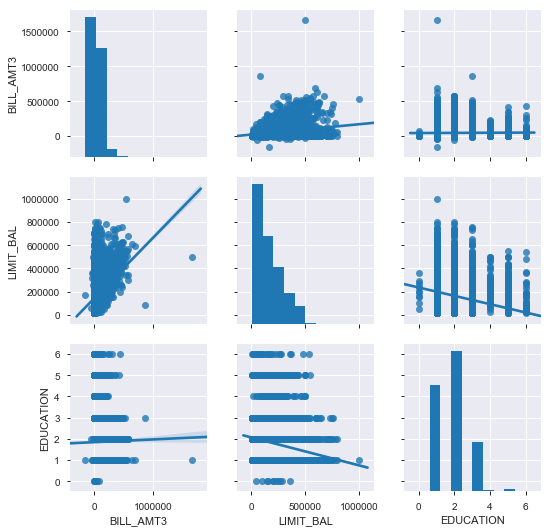

In [90]:
sns.pairplot(data = df[['BILL_AMT3', 'LIMIT_BAL', 'EDUCATION']],kind='reg')

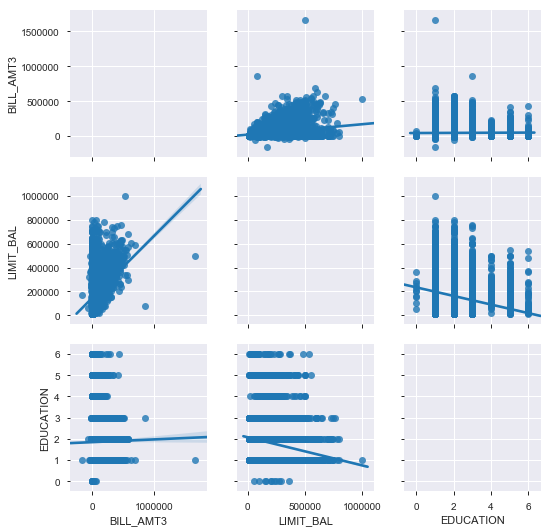

In [89]:
sns.pairplot(data = df[['BILL_AMT3', 'LIMIT_BAL', 'EDUCATION']],kind='reg', diag_kind={'auto', 'hist', 'kde'})

In [ ]:
lgb.cv()